In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# print(tf.__version__)
# import keras
# print(keras.__version__)

In [3]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

import pandas as pd
import numpy as np
from matplotlib import pyplot
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display
%matplotlib inline
import random

# %tensorflow_version 1.x
import tensorflow as tf

from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.model_selection import train_test_split

# Data Class Weight
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard



def FER_Model(input_shape):
    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    #             LSTM Version            #
    # net = layers.LSTM(10, return_sequences=False)(visible)
    net = layers.Dense(64, activation='relu')(visible)
    # net = layers.Dropout(0.2)(net)


    # net = layers.LSTM(5, return_sequences=True)(net)
    net = layers.Dense(32, activation='relu')(net)
    net = layers.Dropout(0.2)(net)

    # net = layers.LSTM(5, return_sequences=True)(visible)
    # net = layers.Dense(16, activation='relu')(net)
    # # net = layers.Dropout(0.2)(net)

    # net = layers.LSTM(1, return_sequences=False)(visible)
    # net = layers.Dense(8, activation='relu')(net)
    # net = layers.Dropout(0.5)(net)

    # net = layers.Conv2D(64, kernel_size=3, padding='same')(visible)
    # net = layers.Activation('relu')(net)
    # net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)

    # shortcut_1 = net

    # net = layers.Conv2D(32, kernel_size=3, padding='same')(net)
    # net = layers.Activation('relu')(net)
    # net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)

    # shortcut_2 = net

#     net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

#     shortcut_3 = net

#     net = layers.Conv2D(128, kernel_size=1, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

    net = layers.Flatten()(net)
    net = layers.Dense(64)(net)
    net = layers.LeakyReLU()(net)
    net = layers.Dense(num_classes, activation='softmax')(net)

    # create model 
    model = Model(inputs =visible, outputs = net)
    # summary layers
    print(model.summary())
    
    return model



seed = 1221
np.random.seed(seed)
random.seed(seed)
# tf.random.set_random_seed(seed)
# tf.random.set_seed(seed)

batch_size = 41
chunk_nums = 4
TVT_size = 6000
test_size = 2000


gdrive_path = '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/'


model_range = range(1229, 1230)
features = [[0, 1, 2, 3], [i for i in range(4, 10)], [i for i in range(10, 16)], [i for i in range(16, 22)], [i for i in range(22, 24)],
            [i for i in range(24, 27)], [i for i in range(27, 30)], [i for i in range(30, 32)], [i for i in range(32, 35)],
            [i for i in range(35, 37)]]
feature_name = ['ohlc', 'minor ST UD', 'Major ST UD', 'minor ST', 'major ST', 'EMA', 
                'minor ST Trend', 'Major ST Trend', 'CB', 'Fisher', 'Trix']
features = [features[0]]          
# print(features)
# break

#     Historical 로 분할한게 새로운 model_num 가 된다.    # --> 형식은 1190_0_1 (Pair_time_testtype) 을 사용
for model_num in model_range:
    
    #       Concat Chunks     #
    for chunk_i in range(chunk_nums):

        temp_Made_X = np.load(gdrive_path + 'Made_X/Made_X %s_%s.npy' % (model_num, chunk_i))
        temp_Made_Y = np.load(gdrive_path + 'Made_X/Made_Y %s_%s.npy' % (model_num, chunk_i)).reshape(-1, 1)

        if chunk_i == 0:
          Made_X = temp_Made_X
          Made_Y = temp_Made_Y    
        else:
          Made_X = np.vstack((Made_X, temp_Made_X))
          Made_Y = np.vstack((Made_Y, temp_Made_Y))

    print('Made_X.shape :', Made_X.shape)
    print('Made_Y.shape :', Made_Y.shape)
    test_nums = int((len(Made_X) - TVT_size) / test_size) + 1

    start_i, end_i = 0, TVT_size - test_size

    # try:
    for test_num in range(test_nums):

      #     Select which part to Train    #
      start_i += test_size
      end_i += test_size

      Made_X2 = Made_X[start_i:end_i]
      Made_Y2 = Made_Y[start_i:end_i]    

      #     Remove np.nan in label rows   #
      nan_row = np.argwhere(np.isnan(Made_Y2))
      Made_X2 = np.delete(Made_X2, nan_row, axis=0)
      Made_Y2 = np.delete(Made_Y2, nan_row, axis=0)

      print('np.sum(np.isnan(Made_X2)) :', np.sum(np.isnan(Made_X2)))
      print('np.sum(np.isnan(Made_Y2)) :', np.sum(np.isnan(Made_Y2)))

      #         Feature Selection      #
      for feature_i in range(len(features)):

        # Made_X = Made_X[:, :, [-4]]
        # Made_X = Made_X[:, :, :4]
        Made_X3 = Made_X2[:, :, features[feature_i]]

        row = Made_X3.shape[1]
        col = Made_X3.shape[2]

        X_train, X_val, Y_train, Y_val = train_test_split(Made_X3, Made_Y2, test_size=0.3,
                                                            shuffle=False)

        print('X_train.shape :', X_train.shape)
        print('X_val.shape :', X_val.shape)


        label = Y_train.reshape(-1, )
        num_classes = len(np.unique(label))
        # print(label.shape)

        Y_train = np_utils.to_categorical(Y_train, num_classes)
        Y_val = np_utils.to_categorical(Y_val, num_classes)
        
        print('Y_train.shape :', Y_train.shape)
        print('Y_val.shape :', Y_val.shape)

        
        #         Get Class_Weights (--> should be considered only for TrainSet)       #
        class_weights = class_weight.compute_class_weight('balanced', 
                                                          classes=np.unique(label),
                                                          y=label)
        class_weights = dict(enumerate(class_weights))
        print(class_weights)
        # quit()

        model = FER_Model((row, col))
        opt = Adam(lr=0.0001, decay=1e-6)

        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
          
            
        filepath = gdrive_path + "model/rapid_ascending %s_%s_%s_futures_rnn.hdf5" % (model_num, test_num, feature_i)
        checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
        checkpoint2 = TensorBoard(log_dir='Tensorboard_graph',
                                  histogram_freq=0,
                                  write_graph=True,
                                  write_images=True)
        checkpoint3 = EarlyStopping(monitor='val_accuracy', patience=100)
        callbacks_list = [checkpoint, checkpoint2, checkpoint3]

        # keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

        # we iterate 200 times over the entire training set
        num_epochs = 1000
        history = model.fit(X_train, Y_train,
                            steps_per_epoch=int(len(X_train) / batch_size), 
                            epochs=num_epochs,  
                            verbose=2,  
                            callbacks=callbacks_list,
                            class_weight=class_weights,
                            validation_data=(X_val, Y_val),  
                            validation_steps=int(len(X_val) / batch_size),
                            shuffle=False)
        
      # except Exception as e:
      #   print('Error occured :', e)


Streaming output truncated to the last 5000 lines.
Epoch 22/1000
62/62 - 0s - loss: 0.6918 - accuracy: 0.3555 - val_loss: 0.7074 - val_accuracy: 0.2796

Epoch 00022: val_accuracy did not improve from 0.80237
Epoch 23/1000
62/62 - 0s - loss: 0.6968 - accuracy: 0.3643 - val_loss: 0.7078 - val_accuracy: 0.2869

Epoch 00023: val_accuracy did not improve from 0.80237
Epoch 24/1000
62/62 - 0s - loss: 0.6916 - accuracy: 0.3590 - val_loss: 0.7077 - val_accuracy: 0.2878

Epoch 00024: val_accuracy did not improve from 0.80237
Epoch 25/1000
62/62 - 0s - loss: 0.6902 - accuracy: 0.3682 - val_loss: 0.7078 - val_accuracy: 0.2878

Epoch 00025: val_accuracy did not improve from 0.80237
Epoch 26/1000
62/62 - 0s - loss: 0.6929 - accuracy: 0.3751 - val_loss: 0.7067 - val_accuracy: 0.2860

Epoch 00026: val_accuracy did not improve from 0.80237
Epoch 27/1000
62/62 - 0s - loss: 0.6964 - accuracy: 0.3916 - val_loss: 0.7067 - val_accuracy: 0.2842

Epoch 00027: val_accuracy did not improve from 0.80237
Epoch 2

### ***Backtest***

test_num : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (1802, 200, 4)
Made_X_test2.shape : (2000, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2717,  800]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([1924,  537]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([793, 263]))
np.unique(Y_test_eval) : (array([0., 1.]), array([1299,  503]))
X_train.shape : (2461, 200, 4)
X_val.shape : (1056, 200, 4)
57/57 [==============================] - 0s 2ms/step - loss: 0.6547 - accuracy: 0.7209
test_eval score : [0.6546715497970581, 0.7208657264709473]
63/63 [==============================] - 0s 2ms/step


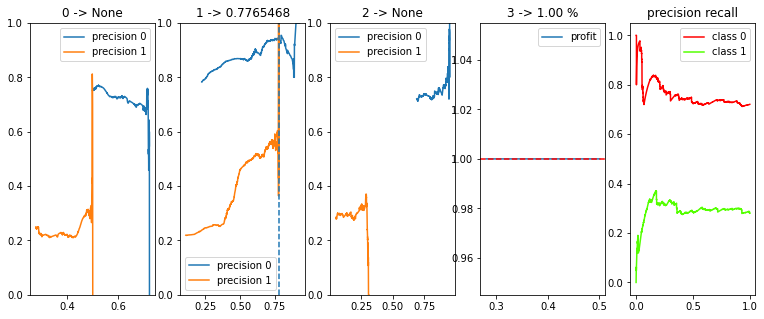

len(total_precision_result) : 3
len(total_recall_result) : 3
len(total_profit_result) : 1


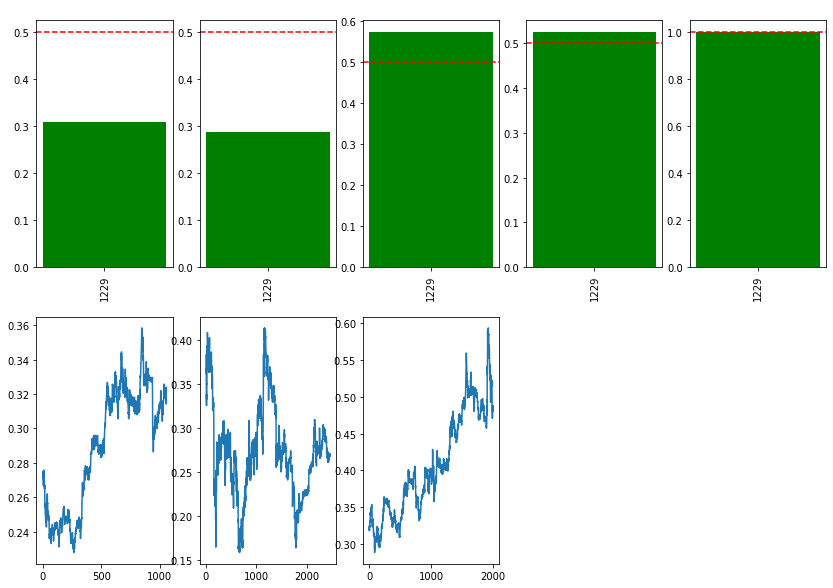

test_num : 1
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (1866, 200, 4)
Made_X_test2.shape : (2000, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2590, 1026]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([1803,  728]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([787, 298]))
np.unique(Y_test_eval) : (array([0., 1.]), array([1406,  460]))
X_train.shape : (2531, 200, 4)
X_val.shape : (1085, 200, 4)
59/59 [==============================] - 0s 2ms/step - loss: 0.6898 - accuracy: 0.7235
test_eval score : [0.6897707581520081, 0.7234726548194885]
63/63 [==============================] - 0s 2ms/step


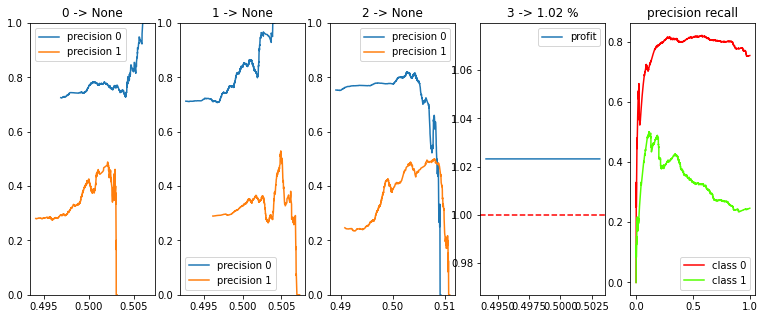

len(total_precision_result) : 3
len(total_recall_result) : 3
len(total_profit_result) : 1


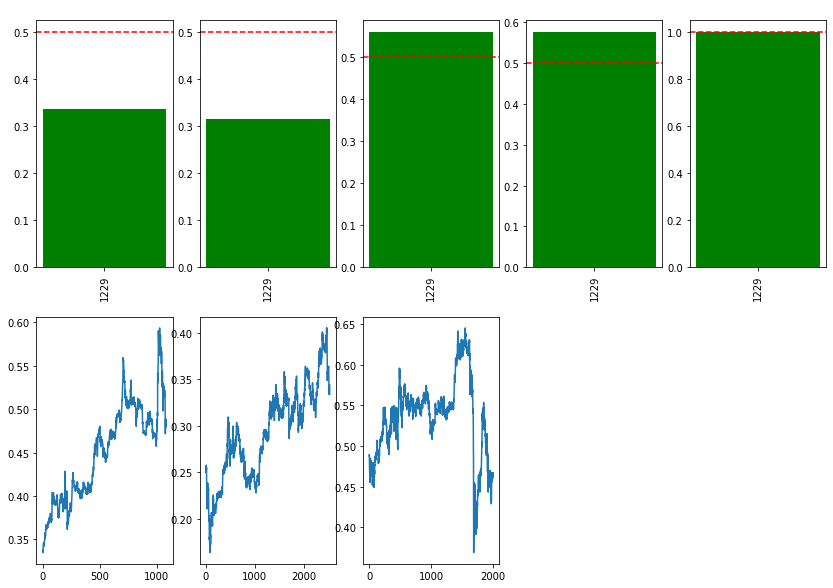

test_num : 2
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (1836, 200, 4)
Made_X_test2.shape : (2000, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2706,  963]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([1916,  652]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([790, 311]))
np.unique(Y_test_eval) : (array([0., 1.]), array([1378,  458]))
X_train.shape : (2568, 200, 4)
X_val.shape : (1101, 200, 4)
58/58 [==============================] - 0s 2ms/step - loss: 0.5739 - accuracy: 0.7505
test_eval score : [0.5738782286643982, 0.7505446672439575]
63/63 [==============================] - 0s 2ms/step


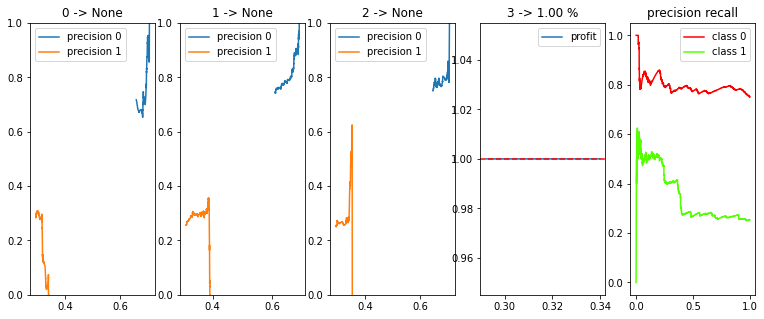

len(total_precision_result) : 3
len(total_recall_result) : 3
len(total_profit_result) : 1


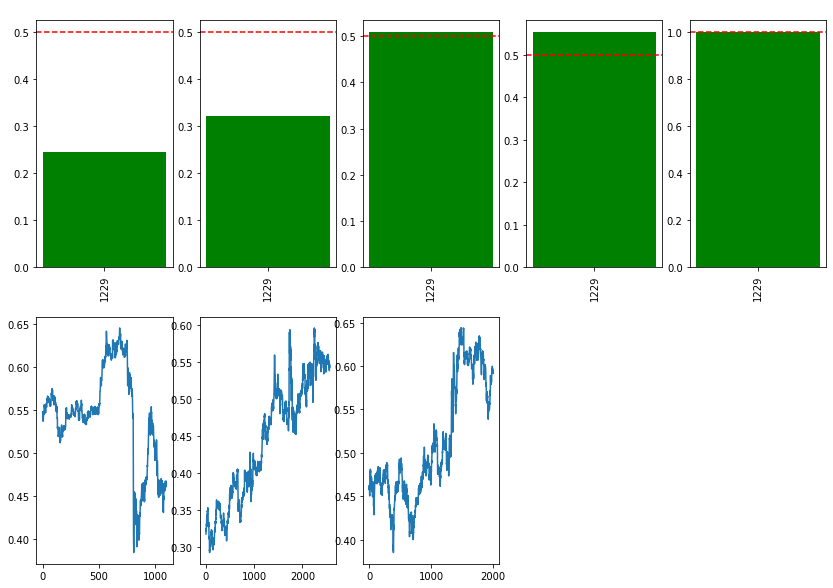

test_num : 3
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (1792, 200, 4)
Made_X_test2.shape : (2000, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2785,  918]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([1963,  629]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([822, 289]))
np.unique(Y_test_eval) : (array([0., 1.]), array([1427,  365]))
X_train.shape : (2592, 200, 4)
X_val.shape : (1111, 200, 4)
56/56 [==============================] - 0s 2ms/step - loss: 0.6878 - accuracy: 0.7048
test_eval score : [0.6877674460411072, 0.7047991156578064]
63/63 [==============================] - 0s 2ms/step


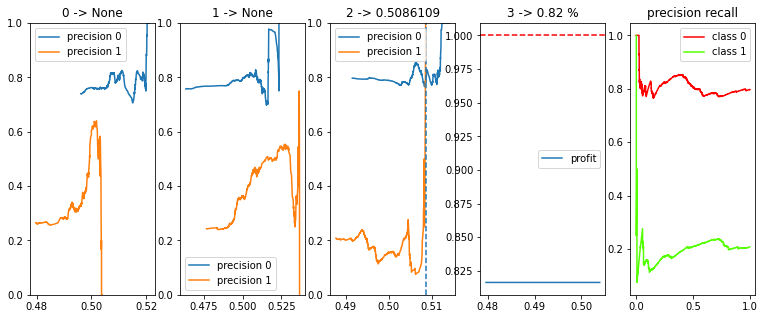

len(total_precision_result) : 3
len(total_recall_result) : 3
len(total_profit_result) : 1


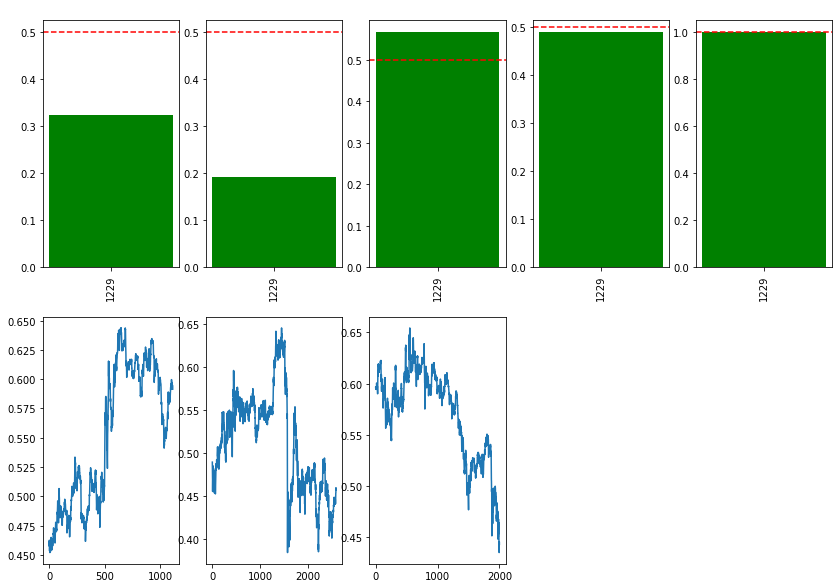

test_num : 4
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (1798, 200, 4)
Made_X_test2.shape : (2000, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2806,  823]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([1893,  647]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([913, 176]))
np.unique(Y_test_eval) : (array([0., 1.]), array([1330,  468]))
X_train.shape : (2540, 200, 4)
X_val.shape : (1089, 200, 4)
57/57 [==============================] - 0s 2ms/step - loss: 0.6676 - accuracy: 0.7397
test_eval score : [0.6676377654075623, 0.739710807800293]
63/63 [==============================] - 0s 2ms/step


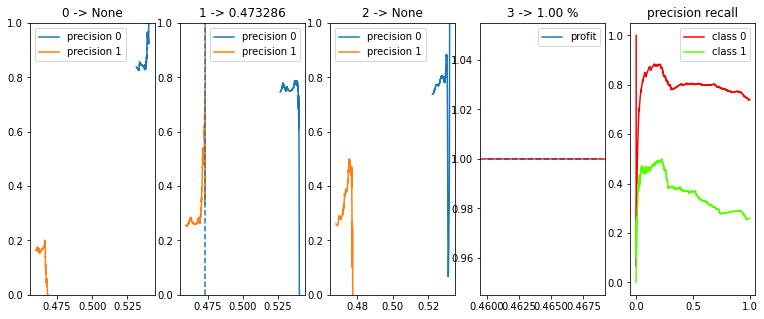

len(total_precision_result) : 3
len(total_recall_result) : 3
len(total_profit_result) : 1


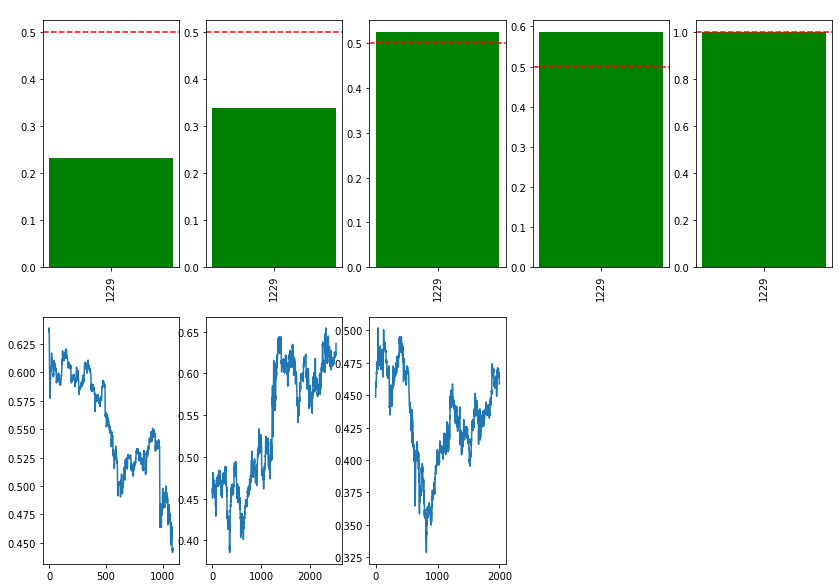

test_num : 5
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (1846, 200, 4)
Made_X_test2.shape : (2000, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2757,  834]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([2007,  506]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([750, 328]))
np.unique(Y_test_eval) : (array([0., 1.]), array([1463,  383]))
X_train.shape : (2513, 200, 4)
X_val.shape : (1078, 200, 4)
58/58 [==============================] - 0s 2ms/step - loss: 0.6915 - accuracy: 0.7925
test_eval score : [0.6914737224578857, 0.7925243973731995]
63/63 [==============================] - 0s 2ms/step


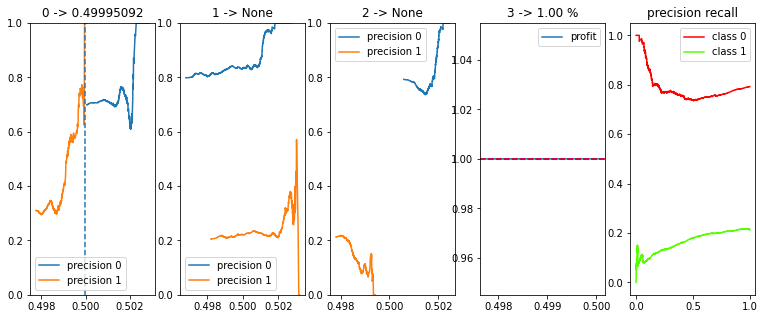

len(total_precision_result) : 3
len(total_recall_result) : 3
len(total_profit_result) : 1


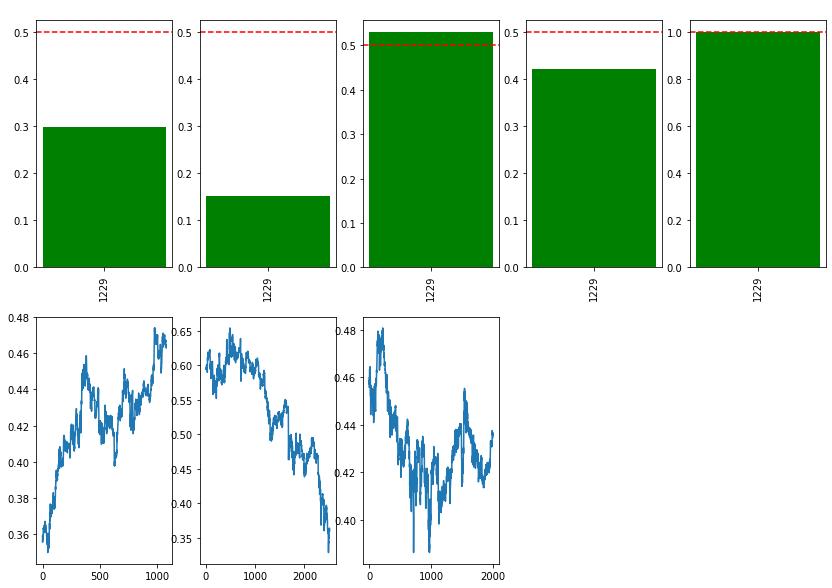

test_num : 6
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (1821, 200, 4)
Made_X_test2.shape : (2000, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2793,  851]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([1981,  569]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([812, 282]))
np.unique(Y_test_eval) : (array([0., 1.]), array([1396,  425]))
X_train.shape : (2550, 200, 4)
X_val.shape : (1094, 200, 4)
57/57 [==============================] - 0s 2ms/step - loss: 0.7267 - accuracy: 0.4371
test_eval score : [0.7266743183135986, 0.4371224641799927]
63/63 [==============================] - 0s 2ms/step


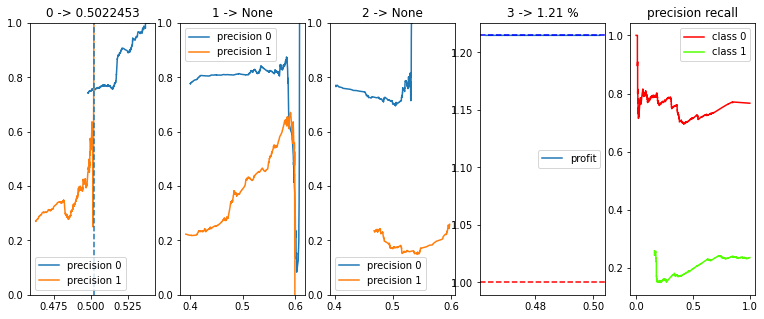

len(total_precision_result) : 3
len(total_recall_result) : 3
len(total_profit_result) : 1


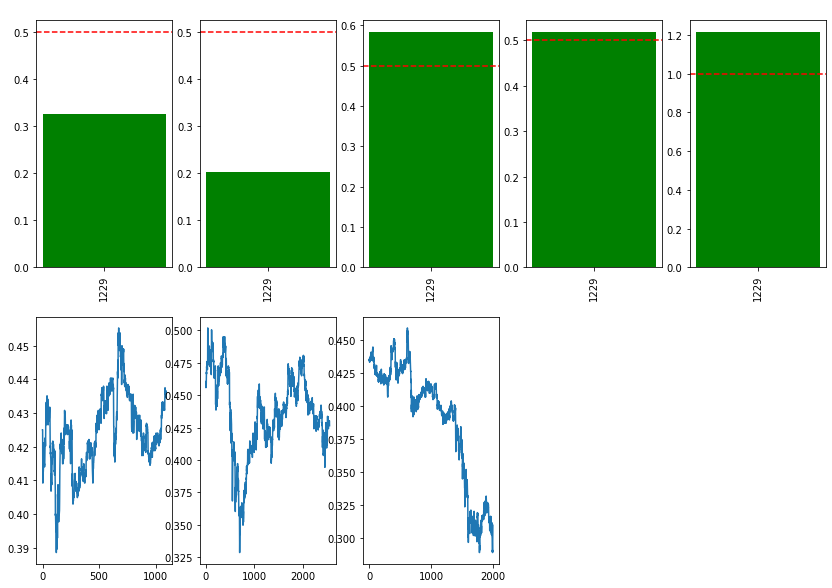

test_num : 7
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (1836, 200, 4)
Made_X_test2.shape : (2000, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2860,  808]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([1988,  579]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([872, 229]))
np.unique(Y_test_eval) : (array([0., 1.]), array([1523,  313]))
X_train.shape : (2567, 200, 4)
X_val.shape : (1101, 200, 4)
58/58 [==============================] - 0s 2ms/step - loss: 0.7870 - accuracy: 0.1705
test_eval score : [0.7869751453399658, 0.17047929763793945]
63/63 [==============================] - 0s 2ms/step


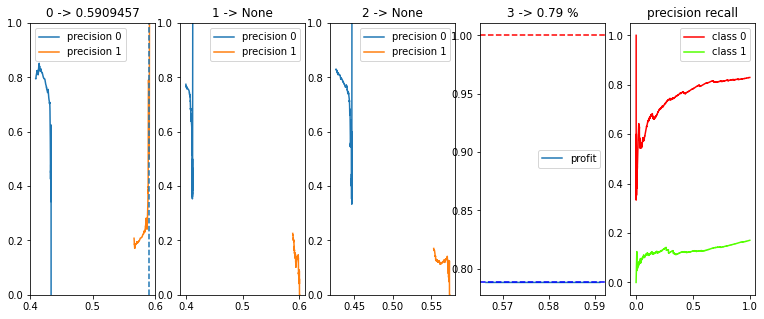

len(total_precision_result) : 3
len(total_recall_result) : 3
len(total_profit_result) : 1


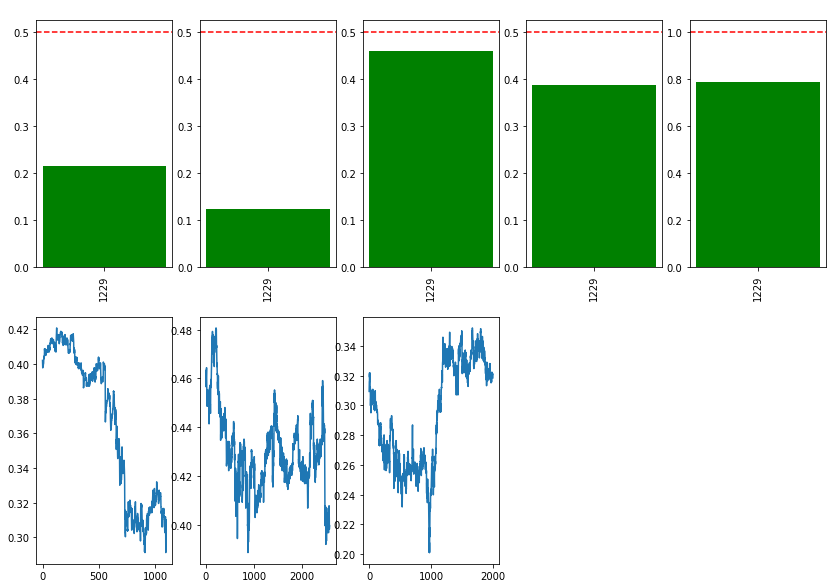

test_num : 8
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (1777, 200, 4)
Made_X_test2.shape : (2000, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2919,  739]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([2038,  522]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([881, 217]))
np.unique(Y_test_eval) : (array([0., 1.]), array([1448,  329]))
X_train.shape : (2560, 200, 4)
X_val.shape : (1098, 200, 4)
56/56 [==============================] - 0s 2ms/step - loss: 0.5788 - accuracy: 0.8149
test_eval score : [0.5788277387619019, 0.8148565292358398]
63/63 [==============================] - 0s 1ms/step


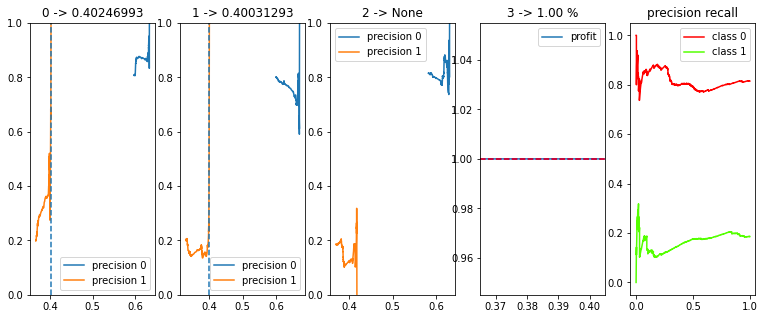

len(total_precision_result) : 3
len(total_recall_result) : 3
len(total_profit_result) : 1


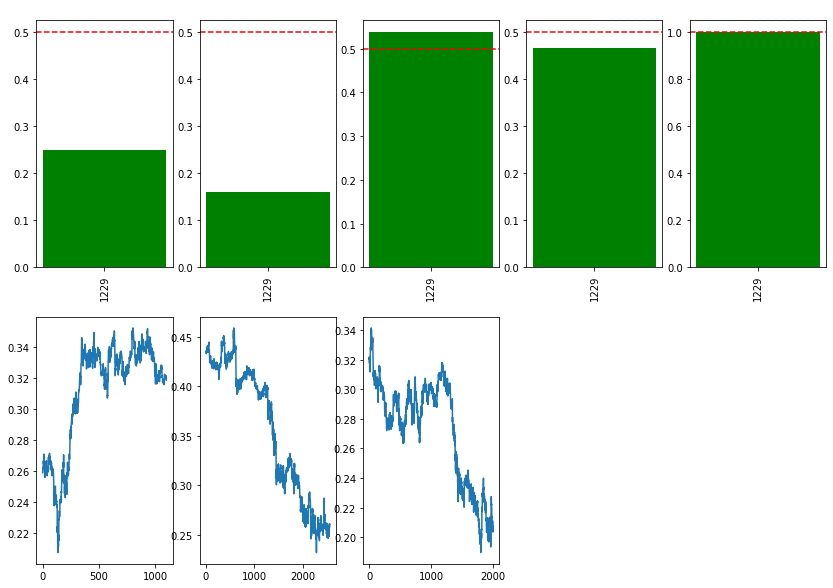

test_num : 9
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (1737, 200, 4)
Made_X_test2.shape : (2000, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2972,  642]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([2062,  467]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([910, 175]))
np.unique(Y_test_eval) : (array([0., 1.]), array([1362,  375]))
X_train.shape : (2529, 200, 4)
X_val.shape : (1085, 200, 4)
55/55 [==============================] - 0s 2ms/step - loss: 0.6918 - accuracy: 0.7841
test_eval score : [0.6918154954910278, 0.7841105461120605]
63/63 [==============================] - 0s 2ms/step


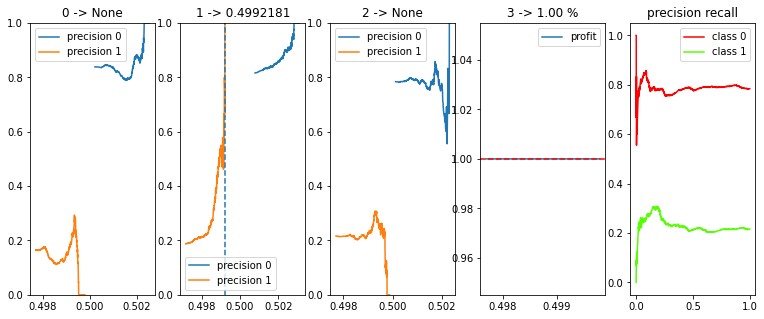

len(total_precision_result) : 3
len(total_recall_result) : 3
len(total_profit_result) : 1


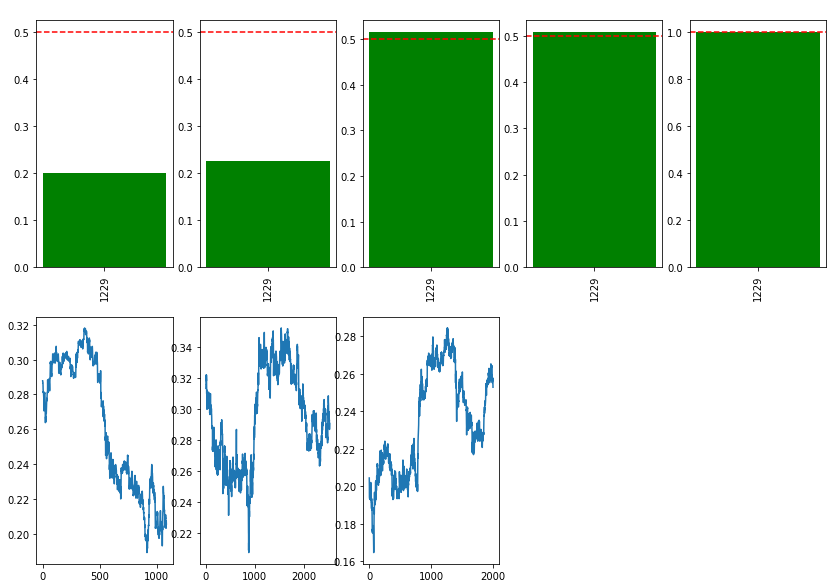

test_num : 10
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (1791, 200, 4)
Made_X_test2.shape : (2000, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2810,  704]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([1981,  478]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([829, 226]))
np.unique(Y_test_eval) : (array([0., 1.]), array([1360,  431]))
X_train.shape : (2459, 200, 4)
X_val.shape : (1055, 200, 4)
56/56 [==============================] - 0s 2ms/step - loss: 0.6210 - accuracy: 0.7594
test_eval score : [0.6210411787033081, 0.7593523263931274]
63/63 [==============================] - 0s 2ms/step


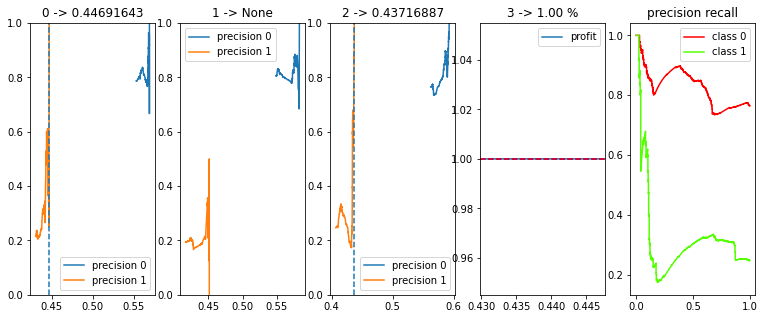

len(total_precision_result) : 3
len(total_recall_result) : 3
len(total_profit_result) : 1


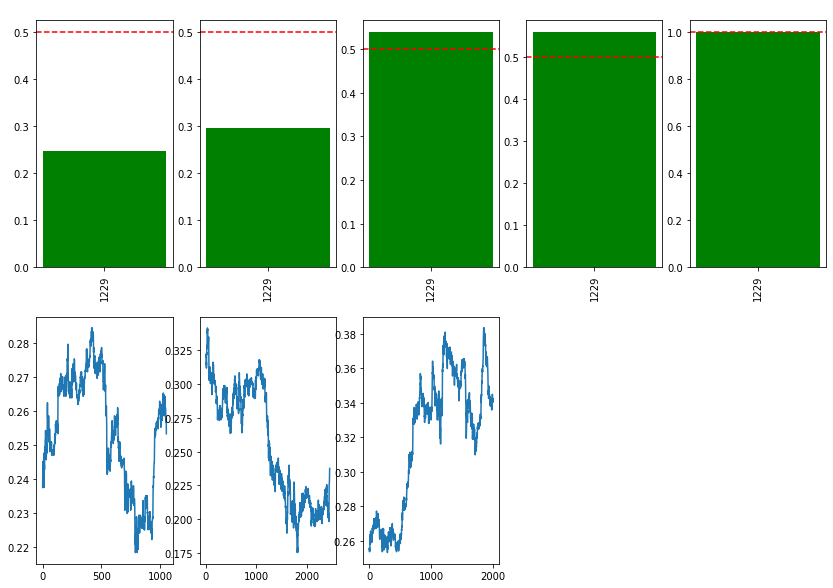

test_num : 11
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (1875, 200, 4)
Made_X_test2.shape : (2000, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2722,  807]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([1875,  595]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([847, 212]))
np.unique(Y_test_eval) : (array([0., 1.]), array([1300,  575]))
X_train.shape : (2470, 200, 4)
X_val.shape : (1059, 200, 4)
59/59 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.6933
test_eval score : [0.6674262285232544, 0.6933333277702332]
63/63 [==============================] - 0s 2ms/step


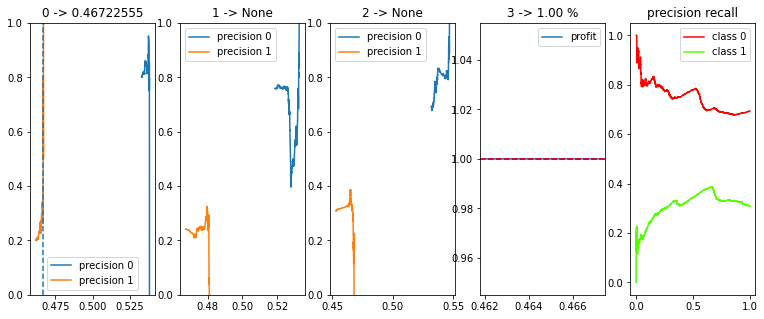

len(total_precision_result) : 3
len(total_recall_result) : 3
len(total_profit_result) : 1


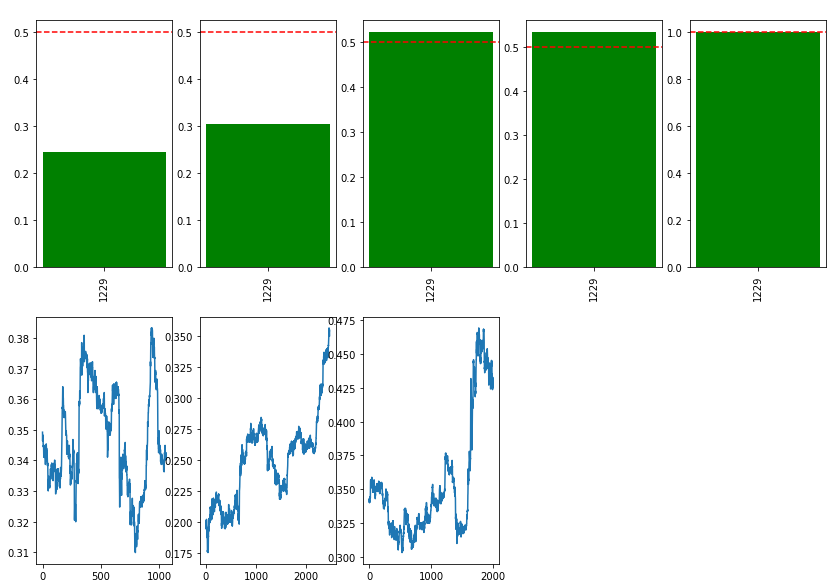

test_num : 12
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (1858, 200, 4)
Made_X_test2.shape : (2000, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2660, 1007]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([1949,  617]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([711, 390]))
np.unique(Y_test_eval) : (array([0., 1.]), array([1292,  566]))
X_train.shape : (2566, 200, 4)
X_val.shape : (1101, 200, 4)
59/59 [==============================] - 0s 2ms/step - loss: 1.0730 - accuracy: 0.6954
test_eval score : [1.0730305910110474, 0.6953713893890381]
63/63 [==============================] - 0s 2ms/step


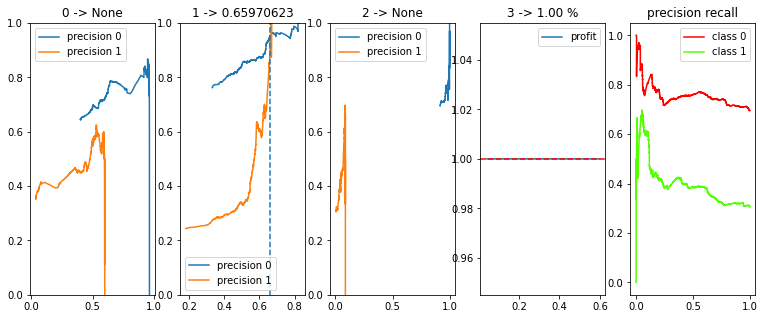

len(total_precision_result) : 3
len(total_recall_result) : 3
len(total_profit_result) : 1


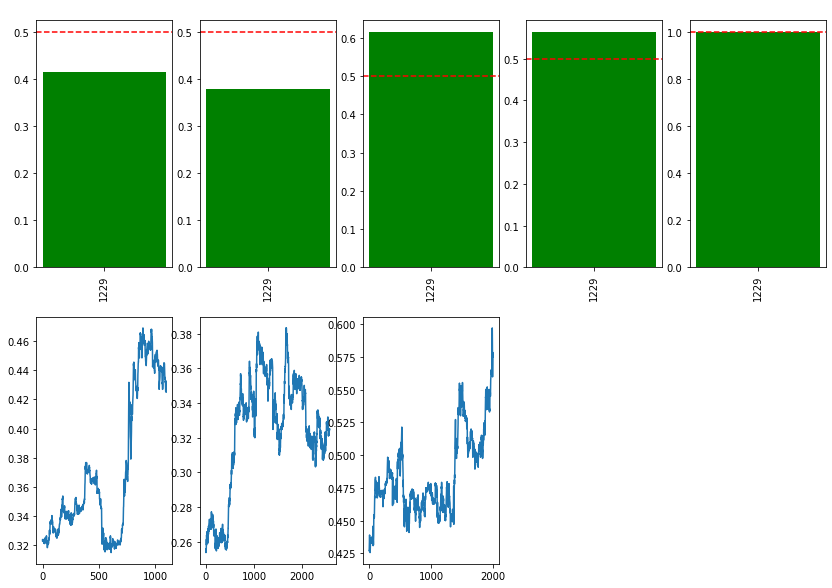

test_num : 13
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (1860, 200, 4)
Made_X_test2.shape : (2000, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2592, 1142]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([1835,  778]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([757, 364]))
np.unique(Y_test_eval) : (array([0., 1.]), array([1418,  442]))
X_train.shape : (2613, 200, 4)
X_val.shape : (1121, 200, 4)
59/59 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.7624
test_eval score : [0.6897424459457397, 0.7623655796051025]
63/63 [==============================] - 0s 2ms/step


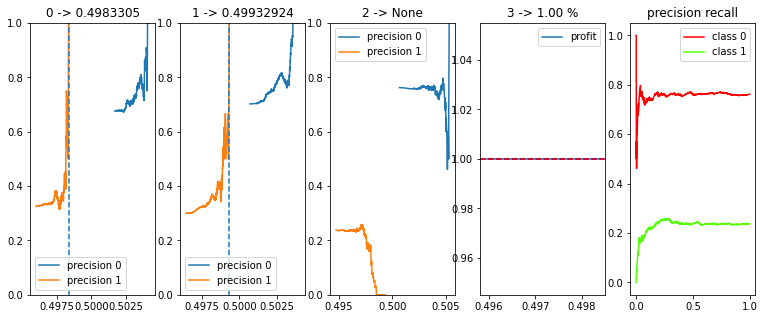

len(total_precision_result) : 3
len(total_recall_result) : 3
len(total_profit_result) : 1


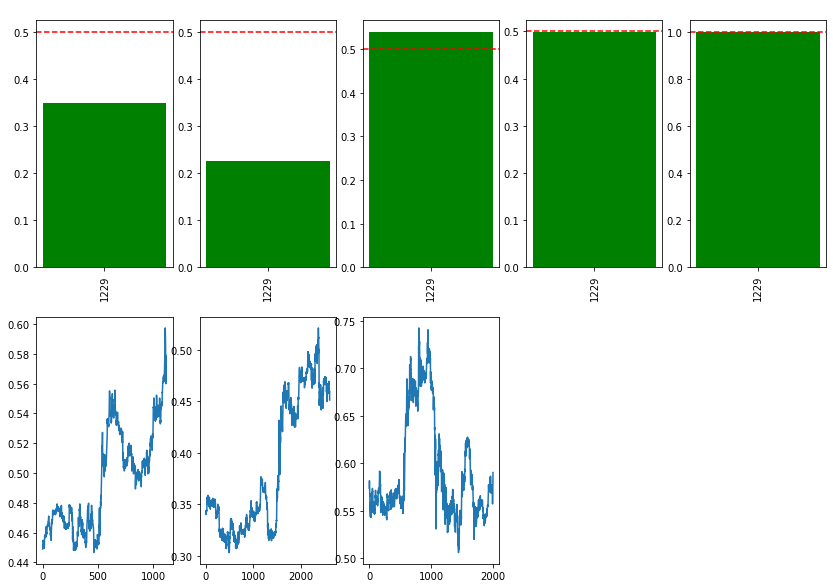

test_num : 14
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (1846, 200, 4)
Made_X_test2.shape : (2000, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2711, 1008]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([1815,  788]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([896, 220]))
np.unique(Y_test_eval) : (array([0., 1.]), array([1402,  444]))
X_train.shape : (2603, 200, 4)
X_val.shape : (1116, 200, 4)
58/58 [==============================] - 0s 2ms/step - loss: 0.6865 - accuracy: 0.7595
test_eval score : [0.6864991784095764, 0.7594799399375916]
63/63 [==============================] - 0s 2ms/step


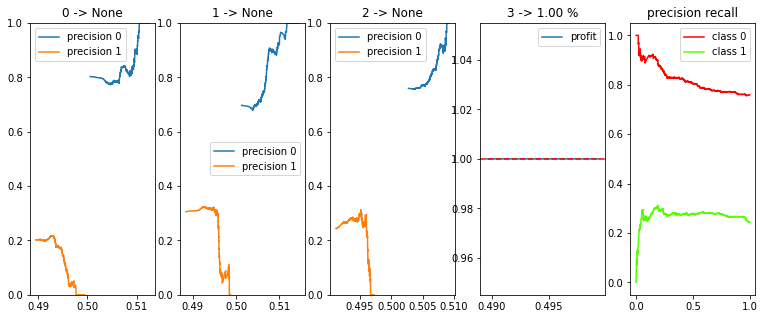

len(total_precision_result) : 3
len(total_recall_result) : 3
len(total_profit_result) : 1


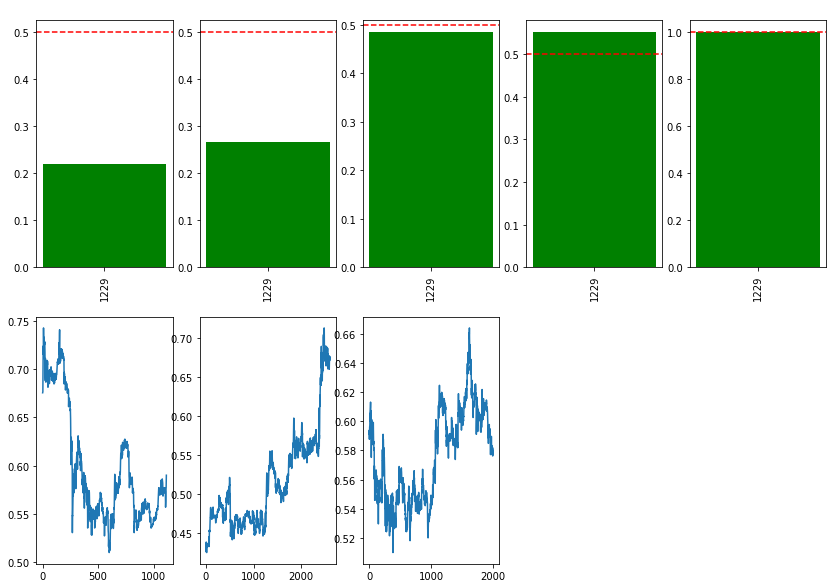

test_num : 15
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (1813, 200, 4)
Made_X_test2.shape : (2000, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2820,  887]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([1987,  607]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([833, 280]))
np.unique(Y_test_eval) : (array([0., 1.]), array([1428,  385]))
X_train.shape : (2594, 200, 4)
X_val.shape : (1113, 200, 4)
57/57 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5019
test_eval score : [0.6930084228515625, 0.5019304752349854]
63/63 [==============================] - 0s 2ms/step


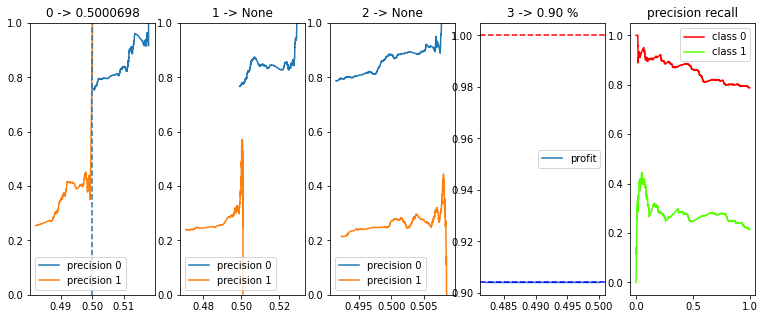

len(total_precision_result) : 3
len(total_recall_result) : 3
len(total_profit_result) : 1


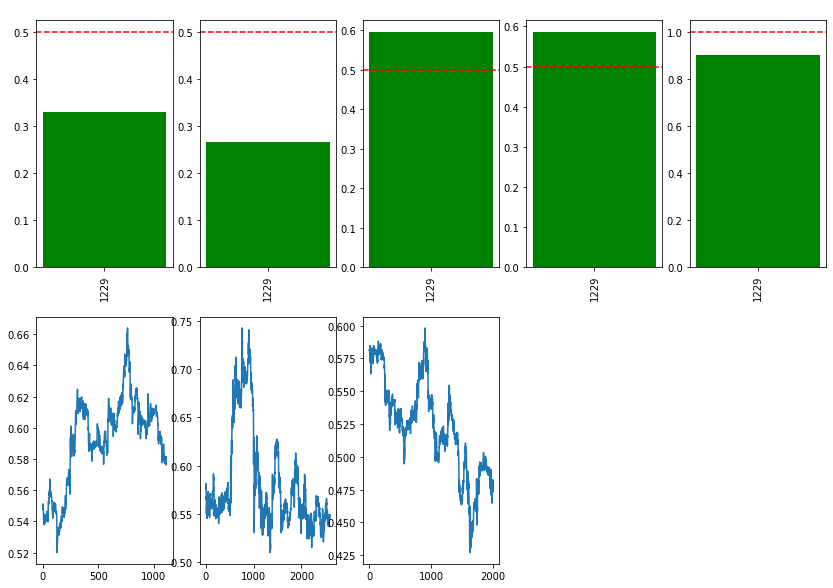

test_num : 16
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (1682, 200, 4)
Made_X_test2.shape : (2000, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2831,  829]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([2017,  545]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([814, 284]))
np.unique(Y_test_eval) : (array([0., 1.]), array([1445,  237]))
X_train.shape : (2562, 200, 4)
X_val.shape : (1098, 200, 4)
53/53 [==============================] - 0s 2ms/step - loss: 0.5197 - accuracy: 0.8591
test_eval score : [0.5196718573570251, 0.8590962886810303]
63/63 [==============================] - 0s 2ms/step


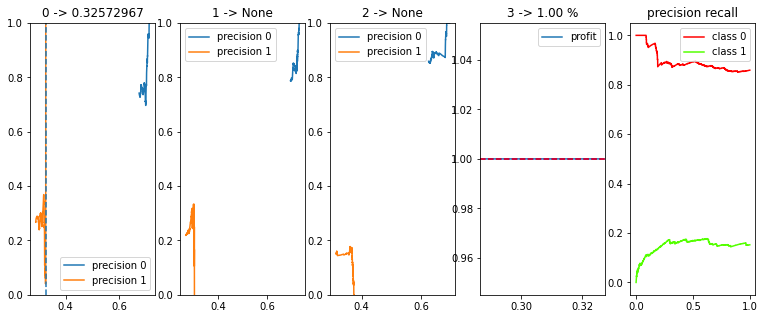

len(total_precision_result) : 3
len(total_recall_result) : 3
len(total_profit_result) : 1


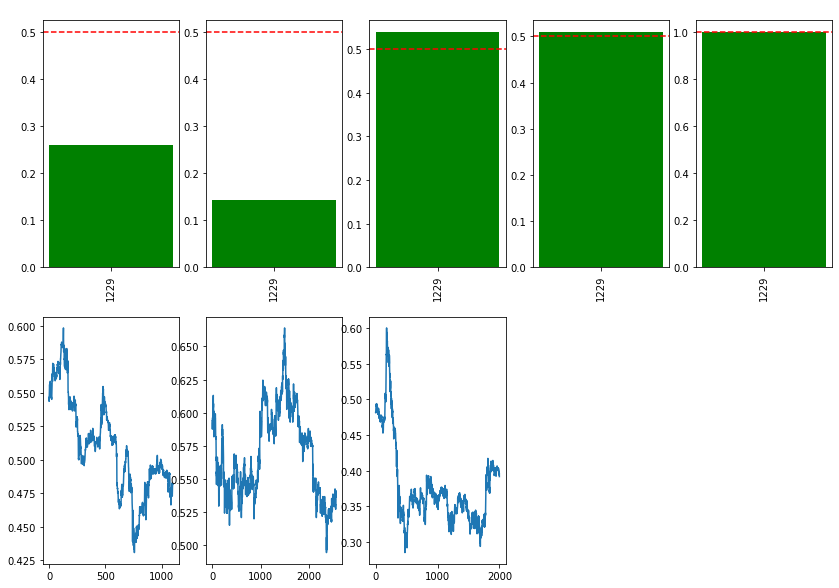

test_num : 17
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_Z.shape : (40004, 4)
np.sum(np.isnan(Made_X2)) : 0
np.sum(np.isnan(Made_Y2)) : 0
np.sum(np.isnan(Made_X_test_eval)) : 0
np.sum(np.isnan(Made_Y_test_eval)) : 0
Made_X.shape : (40004, 200, 37)
Made_Y.shape : (40004, 1)
Made_X_test_eval2.shape : (0, 200, 4)
Made_X_test2.shape : (4, 200, 4)
np.unique(Made_Y) : (array([0., 1.]), array([2873,  623]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([1969,  478]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([904, 145]))
np.unique(Y_test_eval) : (array([], dtype=float64), array([], dtype=int64))
X_train.shape : (2447, 200, 4)
X_val.shape : (1049, 200, 4)
77/77 [==============================] - 0s 2ms/step


ValueError: ignored

In [7]:
#     Confidence value should be adjusted by min max scale in y_pred    #
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

trade_on = True
show_trade_data = False

#      Need for Back-Test     #
input_data_length = X_train.shape[1]
tick_in_box = 30

all_pair_profit_result = list()
all_pair_precision_auc = list()
all_pair_recall_auc = list()
all_pair_auc = list()


# total_length = 10000
# test_nums = int((total_length - TVT_size) / test_size) + 1
# --> test_nums is assigned above cell
start_i, end_i = 0, TVT_size - test_size

for test_num in range(test_nums):

      print('test_num :', test_num)

      #     Select which part to Train    #
      start_i += test_size
      end_i += test_size
      
    # try:
      # try:
      
      total_precision_result = list()
      total_recall_result = list()
      total_auc_result = list()
      total_profit_result = list()
      total_pr = list()

      model_list = model_range
      for model_num in model_list:

        #       Concat Chunks     #
        for chunk_i in range(chunk_nums):

            temp_Made_X = np.load(gdrive_path + 'Made_X/Made_X %s_%s.npy' % (model_num, chunk_i))
            temp_Made_Y = np.load(gdrive_path + 'Made_X/Made_Y %s_%s.npy' % (model_num, chunk_i)).reshape(-1, 1)
            temp_Made_Z = np.load(gdrive_path + 'Made_X/Made_Z %s_%s.npy' % (model_num, chunk_i))


            if chunk_i == 0:
              Made_X = temp_Made_X
              Made_Y = temp_Made_Y    
              Made_Z = temp_Made_Z 
            else:
              Made_X = np.vstack((Made_X, temp_Made_X))
              Made_Y = np.vstack((Made_Y, temp_Made_Y))
              Made_Z = np.vstack((Made_Z, temp_Made_Z))

        print('Made_X.shape :', Made_X.shape)
        print('Made_Y.shape :', Made_Y.shape)
        print('Made_Z.shape :', Made_Z.shape)

        Made_X2 = Made_X[start_i:end_i]
        Made_Y2 = Made_Y[start_i:end_i]   

        Made_X_test = Made_X[end_i:end_i + test_size]    
        Made_Y_test = Made_Y[end_i:end_i + test_size]    
        Made_Z_test = Made_Z[end_i:end_i + test_size]    

        #     Remove np.nan in label rows   #
        nan_row = np.argwhere(np.isnan(Made_Y2))
        Made_X2 = np.delete(Made_X2, nan_row, axis=0)
        Made_Y2 = np.delete(Made_Y2, nan_row, axis=0)

        nan_row = np.argwhere(np.isnan(Made_Y_test))
        Made_X_test_eval = np.delete(Made_X_test, nan_row, axis=0)
        Made_Y_test_eval = np.delete(Made_Y_test, nan_row, axis=0)

        print('np.sum(np.isnan(Made_X2)) :', np.sum(np.isnan(Made_X2)))
        print('np.sum(np.isnan(Made_Y2)) :', np.sum(np.isnan(Made_Y2)))
        print('np.sum(np.isnan(Made_X_test_eval)) :', np.sum(np.isnan(Made_X_test_eval)))
        print('np.sum(np.isnan(Made_Y_test_eval)) :', np.sum(np.isnan(Made_Y_test_eval)))

        # model_list = model_range

      #         Feature Selection      #
      # for specific_num in range(len(model_list)):
        feature_i = 0
        Made_X3 = Made_X2[:, :, features[feature_i]]
        Made_X_test_eval2 = Made_X_test_eval[:, :, features[feature_i]]
        Made_X_test2 = Made_X_test[:, :, features[feature_i]]
        
        # Made_X2 = Made_X2[:, :, [0, 2, 3, 1]]

        print('Made_X.shape :', Made_X.shape)
        print('Made_Y.shape :', Made_Y.shape)
        print('Made_X_test_eval2.shape :', Made_X_test_eval2.shape)
        print('Made_X_test2.shape :', Made_X_test2.shape)

        # print('min(Made_Z_test) :', np.min(Made_Z_test))
        # print(sum(sum(Made_X != Made_X2)))
        # break

        row = Made_X3.shape[1]
        col = Made_X3.shape[2]

        X_train, X_val, Y_train, Y_val = train_test_split(Made_X3, Made_Y2, test_size=0.3,
                                                            shuffle=False)
        X_train = X_train.astype('float32')#.reshape(-1, input_data_length, col, 1)
        X_val = X_val.astype('float32')#.reshape(-1, input_data_length, col, 1)

        input_data_length = X_train.shape[1]

        X_test_eval = Made_X_test_eval2
        X_test = Made_X_test2

        Y_train = Y_train.astype('float32')
        Y_val = Y_val.astype('float32')          
        Y_test_eval = Made_Y_test_eval
        Y_test = Made_Y_test
        print('np.unique(Made_Y) :', np.unique(Made_Y2, return_counts=True))
        print('np.unique(Y_train) :', np.unique(Y_train, return_counts=True))
        print('np.unique(Y_val) :', np.unique(Y_val, return_counts=True))
        print('np.unique(Y_test_eval) :', np.unique(Y_test_eval, return_counts=True))

        num_classes = len(np.unique(Y_train))

        Y_train = np_utils.to_categorical(Y_train, num_classes)
        Y_val = np_utils.to_categorical(Y_val, num_classes)
        Y_test_eval = np_utils.to_categorical(Y_test_eval, num_classes)
        
        print('X_train.shape :', X_train.shape)
        print('X_val.shape :', X_val.shape)

        model_path = gdrive_path + "model/rapid_ascending %s_%s_%s_futures_rnn.hdf5" % (model_num, test_num, feature_i)
        model = load_model(model_path)

        val_y_pred_ = model.predict(X_val, verbose=1)
        train_y_pred_ = model.predict(X_train, verbose=1)
        test_eval_y_pred_ = model.predict(X_test_eval, verbose=1)

        print('test_eval score :', model.evaluate(X_test_eval, Y_test_eval, verbose=1))
        test_y_pred_ = model.predict(X_test, verbose=1)

        target_index = 1
        order_type = 'long'

        plt.figure(figsize=(13, 5))
        for index, y_pred_ in enumerate([val_y_pred_, train_y_pred_, test_eval_y_pred_, test_y_pred_]):

          # print('len(y_pred_) :', len(y_pred_))
          target_score = y_pred_[:, [target_index]]

          # if index == 0:
          #   _, model_acc = model.evaluate(X_val, Y_val, batch_size=batch_size)
          # elif index == 1:
          #   _, model_acc = model.evaluate(X_train, Y_train, batch_size=batch_size)

          precision_result = list()
          f1_result = list()
          profit_result = list()        

          if index != 3:
                
            if index == 0:
              t_te = np.argmax(Y_val, axis=1)
            elif index == 1:
              t_te = np.argmax(Y_train, axis=1)
            elif index == 2:
              t_te = np.argmax(Y_test_eval, axis=1)

              plt.subplot(1, 5, index + 3)
              cmap = plt.cm.get_cmap(name='prism', lut=(num_classes))
              for target_i in range(num_classes):

                temp_t_te = np.where(t_te == target_i, 1, 0)
                target_precision = 0.9
                          
                try:
                  #     precision recall curve   #
                  precision, recall, threshold = precision_recall_curve(temp_t_te, y_pred_[:, [target_i]])
                  precision, recall = precision[:-1], recall[:-1]
                except Exception as e:
                  print('Error in for loop pr curve :', e)

                plt.plot(recall, precision, label='class {}'.format(target_i), c=cmap(target_i))
              plt.legend()
              plt.title('precision recall')
              
            plt.subplot(1, 5, index + 1)

            for target_i in [0, 1]:
              #       TVT without np.nan    #
              temp_t_te = np.where(t_te == target_i, 1, 0)
              target_precision = 0.9
                        
              try:
                #     precision recall curve   #
                precision, recall, threshold = precision_recall_curve(temp_t_te, y_pred_[:, [target_i]])
                precision, recall = precision[:-1], recall[:-1]
              except Exception as e:
                print('Error in for loop pr curve :', e)

              plt.plot(threshold, precision, label='precision %s' % target_i)

              if target_i == target_index:
                precision_arg = np.argwhere(precision >= target_precision)
                
                if index == 0:
                  profit_threshold = threshold
                  profit_precision_arg = precision_arg

                if len(precision_arg) != 0:
                  thr_precision = threshold[np.min(precision_arg)]
                  plt.axvline(thr_precision, linestyle='--')
                  plt.title('%s -> %s' % (index, thr_precision))
                else:
                  plt.title('%s -> %s' % (index, None))

                #     auc is mean (target)    #          
                total_precision_result.append(np.mean(precision))
                total_recall_result.append(np.mean(recall))

            plt.legend()
            plt.ylim(0, 1)
            # total_auc_result.append(auc_)
            # total_pr.append((fpr, tpr)  

            # plt.plot(recall, precision)
            # baseline = len(t_te[t_te==1]) / len(t_te)
            # plt.axhline(baseline, linestyle='--', color='red')
            # plt.title(index)
            # plt.show()

            #     label binarize     #
            # f1 = f1_score(t_te, y_pred) * 100
        
            #   fpr, tpr, thr = roc_curve(t_te, target_score)
            #   auc_ = auc(fpr, tpr) * 100       

          #       Trading Session, Accumulate Profit     #
          else:

            for thr in profit_threshold:

              y_pred = np.where(target_score >= .5, 1, 0).reshape(-1, )
              # y_pred = np.where(target_score >= thr, 1, 0).reshape(-1, )

              accumulated_profit = 1.

              if trade_on:
                tp_ratio = 3
                target_percentage = 0.05
                inverse = False
                if inverse:
                  target_percentage = -target_percentage
                sl_least_gap_ratio = 0.1

                marker_on = False
                try:
                  if thr == thr_precision:
                    marker_on = True
                    long_marker_x = list()
                    long_marker_y = list()
                    tp_marker_x = list()
                    tp_marker_y = list()
                    sl_marker_x = list()
                    sl_marker_y = list()
                    tp_level_list_x = list()
                    tp_level_list_y = list()
                    sl_level_list_x = list()
                    sl_level_list_y = list()
                except:
                  pass

                #         This column order should be changed     #
                high, low, close = np.split(Made_Z_test[:, 1:4], 3, axis=1) # <-- Column Order should be changed
                # break
                i = input_data_length
                while (i < len(y_pred)):

                  #     Long Short Levels    #
                  if y_pred[i] == 1:  

                    ep = close[i]
                    box_high = high[i + 1 - tick_in_box: i + 1].max()
                    box_low = low[i + 1 - tick_in_box: i + 1].min()

                    # print('box_high, box_low :', box_high, box_low)
                    long_sl = ep - min(abs(ep - box_high), abs(ep - box_low))
                    tp_level_0 = (close[i] - long_sl) * tp_ratio * 1/3 + close[i]
                    tp_level_1 = (close[i] - long_sl) * tp_ratio * 2/3 + close[i]
                    tp_level = (close[i] - long_sl) * tp_ratio + close[i]

                    short_sl = ep + max(abs(ep - box_high), abs(ep - box_low))
                    short_tp = close[i] - abs(close[i] - short_sl) * tp_ratio
                    short_tp_0 = close[i] - abs(close[i] - short_sl) * tp_ratio * 1/3
                    short_tp_1 = close[i] - abs(close[i] - short_sl) * tp_ratio * 2/3
                    tp_count = 3

                    #       Consider 'sl_least_gap'     #
                    if order_type == 'short':
                      if not close[i] <= short_sl - abs(short_sl - long_sl) * sl_least_gap_ratio:
                        i += 1
                        if i >= len(y_pred):
                          break
                        continue
                    else:
                      if not close[i] >= long_sl + (short_sl - long_sl) * sl_least_gap_ratio:
                        i += 1
                        if i >= len(y_pred):
                          break
                        continue

                    if show_trade_data: print(i, 'long')

                    if marker_on:
                      long_marker_x.append(i)
                      long_marker_y.append(close[i])

                    if i + 1 >= len(y_pred):
                      break
                    
                    for j in range(i + 1, len(y_pred)):

                      if show_trade_data: print(long_sl, low[j], high[j], tp_level)
                      if marker_on:
                        tp_level_list_x.append(j)
                        tp_level_list_y.append(tp_level)

                      if order_type == 'short':
                        if low[j] < short_tp_0 and tp_count == 3:
                          accumulated_profit *= 1 + target_percentage * tp_ratio * 1/3 * .25
                          tp_count -= 1
                        if low[j] < short_tp_1 and tp_count == 2:
                          accumulated_profit *= 1 + target_percentage * tp_ratio * 2/3 * .25
                          tp_count -= 1
                        if low[j] < short_tp and tp_count == 1:
                          accumulated_profit *= 1 + target_percentage * tp_ratio * .5
                          if show_trade_data: print(j, 'tp, accum.profit :', accumulated_profit)  
                          if marker_on:
                            tp_marker_x.append(j)
                            tp_marker_y.append(low[j])
                          break
                        
                        elif high[j] > short_sl:
                          accumulated_profit *= 1 - target_percentage
                          if show_trade_data: print(j, 'tp, accum.profit :', accumulated_profit) 
                          if marker_on:         
                            sl_marker_x.append(j)
                            sl_marker_y.append(high[j])
                          break
                      
                      else:
                        if high[j] > tp_level_0 and tp_count == 3:
                          accumulated_profit *= 1 + target_percentage * tp_ratio * 1/3 * .25
                          tp_count -= 1
                        elif high[j] > tp_level_0 and tp_count == 2:
                          accumulated_profit *= 1 + target_percentage * tp_ratio * 2/3 * .25
                          tp_count -= 1
                        elif high[j] > tp_level and tp_count == 1:
                          accumulated_profit *= 1 + target_percentage * tp_ratio * .5
                          if show_trade_data: print(j, 'tp, accum.profit :', accumulated_profit)                            
                          if marker_on:
                            tp_marker_x.append(j)
                            tp_marker_y.append(high[j])
                          break
                        
                        elif low[j] < long_sl:
                          accumulated_profit *= 1 - target_percentage
                          if show_trade_data: print(j, 'tp, accum.profit :', accumulated_profit)          
                          if marker_on:                          
                            sl_marker_x.append(j)
                            sl_marker_y.append(low[j])
                          break

                    i = j

                  i += 1
                  # print('i, len(y_pred) :', i, len(y_pred))
                  if i >= len(y_pred):
                    break

              profit_result.append(accumulated_profit)
            
            #     thresh loop outscope    #
            plt.subplot(1, 5, index + 1)
            plt.plot(profit_threshold, profit_result, label='profit')
            plt.legend()
            if len(profit_precision_arg) != 0:
              thr_profit = profit_result[np.min(profit_precision_arg)]
              plt.axhline(thr_profit, linestyle='--', color='b')
            else:
              thr_profit = 1.
            plt.axhline(1., linestyle='--', color='r')
            # plt.title('%s -> %.2f %%' % (index, thr_profit))
            plt.title('%s -> %.2f %%' % (index, accumulated_profit))
            plt.show()

            total_profit_result.append(thr_profit)  


      #       same indent with loop for model_list    #
      print('len(total_precision_result) :', len(total_precision_result))
      print('len(total_recall_result) :', len(total_recall_result))
      # print('len(total_auc_result) :', len(total_auc_result))
      print('len(total_profit_result) :', len(total_profit_result))

      cmap = plt.cm.get_cmap(name='prism', lut=(len(model_list)))
      plt.figure(figsize=(20, 10))

      #         Show Precision by confidence    #
      #       even index => Val / odd index => Train    #
      plt.subplot(2, 7, 1)
      mean_precision = np.mean(np.array([total_precision_result[0::3], total_precision_result[1::3]]), axis=0)
      # print(mean_precision[0][1:5])
      mean_precision_auc = [mean_precision[auc_i] for auc_i in range(len(model_list))]
      # for i in range(len(model_list)):
      #   plt.plot(x_ticks, mean_precision[i], label='%s' % i, c=cmap(i))
      plt.bar(range(len(model_list)), mean_precision_auc, color='g')
      plt.xticks(range(len(model_list)), model_list, rotation=90)
      plt.axhline(.5, linestyle='--', color='red')
      # plt.ylim(-5, 105)
      # plt.legend()
      plt.title('Mean Precision AUC', color='white', fontsize=10)

      plt.subplot(2, 7, 2)
      test_precision = total_precision_result[2::3]
      # print(test_precision[0][1:5])
      test_precision_auc = [test_precision[auc_i] for auc_i in range(len(model_list))]
      # for i in range(len(model_list)):
      #   plt.plot(x_ticks, test_precision[i], label='%s' % i, c=cmap(i))
      plt.bar(range(len(model_list)), test_precision_auc, color='g')
      plt.xticks(range(len(model_list)), model_list, rotation=90)
      plt.axhline(.5, linestyle='--', color='red')
      # plt.ylim(-5, 105)
      # plt.legend()
      plt.title('Test Precision AUC', color='white', fontsize=10)
      
      plt.subplot(2, 7, 3)
      mean_recall = np.mean(np.array([total_recall_result[0::3], total_recall_result[1::3]]), axis=0)
      mean_recall_auc = [mean_recall[auc_i] for auc_i in range(len(model_list))]
      # for i in range(len(model_list)):
      #   plt.plot(x_ticks, mean_recall[i], label='%s' % i, c=cmap(i))
      plt.bar(range(len(model_list)), mean_recall_auc, color='g')
      plt.xticks(range(len(model_list)), model_list, rotation=90)
      plt.axhline(.5, linestyle='--', color='red')
      # plt.ylim(-5, 105)
      # plt.legend()
      plt.title('Mean Recall AUC', color='white', fontsize=10) 

      plt.subplot(2, 7, 4)
      test_recall = total_recall_result[2::3]
      test_recall_auc = [test_recall[auc_i] for auc_i in range(len(model_list))]
      # for i in range(len(model_list)):
      #   plt.plot(x_ticks, test_recall[i], label='%s' % i, c=cmap(i))
      plt.bar(range(len(model_list)), test_recall_auc, color='g')
      plt.xticks(range(len(model_list)), model_list, rotation=90)
      plt.axhline(.5, linestyle='--', color='red')
      # plt.ylim(-5, 105)
      # plt.legend()
      plt.title('Test Recall AUC', color='white', fontsize=10) 

      plt.subplot(2, 7, 5)
      #         Can compare only AUC      # --> Different length (fpr, tpr)
      test_profit = total_profit_result
      test_profit_auc = [test_profit[auc_i] for auc_i in range(len(model_list))]
      plt.bar(range(len(model_list)), test_profit_auc, color='g')
      plt.xticks(range(len(model_list)), model_list, rotation=90)
      plt.axhline(1., linestyle='--', color='red')
      plt.title('Test Profit AUC', color='white', fontsize=10)   

      # plt.subplot(2, 7, 6)
      # #         Can compare only AUC      # --> Different length (fpr, tpr)
      # test_auc = total_auc_result[2::3]
      # plt.bar(range(len(model_list)), test_auc, color='g')
      # plt.xticks(range(len(model_list)), model_list, rotation=90)
      # plt.ylim(-5, 105)
      # plt.axhli.5(50, linestyle='--', color='red')
      # plt.title('Test AUC', color='white', fontsize=10) 

      plt.subplot(2, 7, 8)
      plt.plot(Made_X2[-len(X_val):, [-1], [3]])
      plt.subplot(2, 7, 9)
      plt.plot(Made_X2[:len(X_train), [-1], [3]])
      plt.subplot(2, 7, 10)
      plt.plot(Made_Z_test[:, 3])

      plt.show()

      all_pair_precision_auc.append(test_precision_auc)
      all_pair_recall_auc.append(test_recall_auc)
      # all_pair_profit.append(mean_auc)
      all_pair_profit_result.append(test_profit_auc)


        #   except Exception as e:
        #     print('Error occured : ', e)
        # print()

        # break



### ***Compare Result***

(25, 4)
(25, 4)
(25, 4)


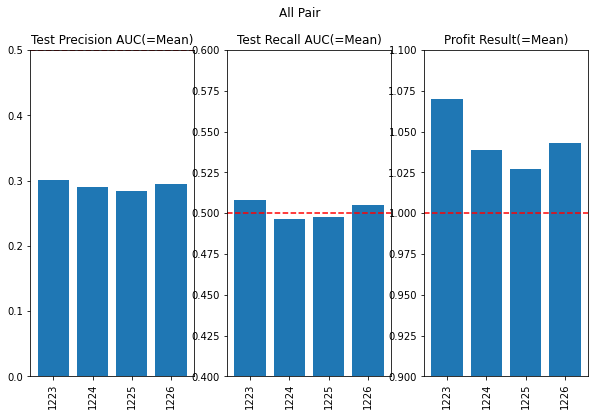

In [ ]:
print(np.array(all_pair_precision_auc).shape)
print(np.array(all_pair_recall_auc).shape)
print(np.array(all_pair_profit_result).shape)

# print(np.sum(np.array(all_pair_precision_auc), axis=0))
fig = plt.figure(figsize=(10, 6))
plt.subplot(131)
plt.bar(range(len(model_list)), np.mean(np.array(all_pair_precision_auc), axis=0))
plt.axhline(.5, linestyle='--', color='red')
plt.xticks(range(len(model_list)), model_list, rotation=90)
plt.ylim(.0, .5)
plt.title('Test Precision AUC(=Mean)')

plt.subplot(132)
plt.bar(range(len(model_list)), np.mean(np.array(all_pair_recall_auc), axis=0))
plt.axhline(.5, linestyle='--', color='red')
plt.xticks(range(len(model_list)), model_list, rotation=90)
plt.ylim(.4, .6)
plt.title('Test Recall AUC(=Mean)')

plt.subplot(133)
plt.bar(range(len(model_list)), np.mean(np.array(all_pair_profit_result), axis=0))
plt.axhline(1., linestyle='--', color='red')
plt.xticks(range(len(model_list)), model_list, rotation=90)
plt.ylim(.9, 1.1)
plt.title('Profit Result(=Mean)')

fig.suptitle('All Pair') # or plt.suptitle('Main title')

plt.show()

### ***AUC***

In [ ]:
#     Confidence value should be adjusted by min max scale in y_pred    #
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score, precision_score, recall_score


trade_on = True
show_trade_data = False

input_data_length = 30 # <-- Need for Back-Test
test_model_range = range(1044, 1078)
total_profit_result = list()
for model_num, test_model_num in zip(model_range, test_model_range):

  # try:

    Made_X_ = np.load(gdrive_path + 'Made_X/Made_X %s.npy' % model_num)
    Made_Y = np.load(gdrive_path + 'Made_X/Made_Y %s.npy' % model_num).reshape(-1, 1)

    Made_X_test_ = np.load(gdrive_path + 'Made_X/Made_X %s.npy' % test_model_num)
    #     for trade, ohlc data    #
    Made_Z_test = np.load(gdrive_path + 'Made_X/Made_Z %s.npy' % test_model_num)

    # Made_X2 = np.load(gdrive_path + 'Made_X/Made_X 30_%s.npy' % (30, 219))
    # Made_Y2 = np.load(gdrive_path + 'Made_X/Made_Y 30_%s.npy' % (30, 219))

    #         Feature Selection      #
    # Made_X = Made_X_[:, :, [-4]]
    # Made_X = Made_X_[:, :, :4]
    Made_X = Made_X_[:, :, :4]
    # Made_X2 = Made_X2[:, :, [0, 2, 3, 1]]


    #         Train Limit         #
    # Made_X = Made_X[-4000:]
    # Made_Y = Made_Y[-4000:]
    Made_X_test = Made_X_test_[:, :, :4]
    print('Made_X.shape :', Made_X.shape)
    print('Made_Y.shape :', Made_Y.shape)
    print('Made_X_test.shape :', Made_X_test.shape)
    print('Made_Z_test.shape :', Made_Z_test.shape)

    # print('min(Made_Z_test) :', np.min(Made_Z_test))
    # print(sum(sum(Made_X != Made_X2)))
    # break

    row = Made_X.shape[1]
    col = Made_X.shape[2]

    X_train, X_val, Y_train, Y_val = train_test_split(Made_X, Made_Y, test_size=0.3,
                                                        shuffle=False)
    X_train = X_train.astype('float32')#.reshape(-1, input_data_length, col, 1)
    X_val = X_val.astype('float32')#.reshape(-1, input_data_length, col, 1)

    Y_train = Y_train.astype('float32')
    Y_val = Y_val.astype('float32')
    
    X_test = Made_X_test
    print('np.unique(Made_Y) :', np.unique(Made_Y, return_counts=True))
    print('np.unique(Y_train) :', np.unique(Y_train, return_counts=True))
    print('np.unique(Y_val) :', np.unique(Y_val, return_counts=True))

    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_val = np_utils.to_categorical(Y_val, num_classes)
    
    print('X_train.shape :', X_train.shape)
    print('X_val.shape :', X_val.shape)

      
    for model_i, model_num in enumerate([model_num]):

      print('model_num :', model_num)
      if model_i == 0:
        print('Pred by Real')
      else:
        print('Pred by None Real')

      model_path = gdrive_path + "model/rapid_ascending %s_futures_rnn.hdf5" % model_num
      model = load_model(model_path)

      #     val, train -> confidence 와 evaluate 용
      val_y_pred_ = model.predict(X_val, verbose=1)
      train_y_pred_ = model.predict(X_train, verbose=1)

      # val_y_pred_ = np.argmax(val_y_pred_, axis=1)
      val_y_pred_ = val_y_pred_[:, [1]]
      train_y_pred_ = train_y_pred_[:, [1]]

      # print('len(val_y_pred_) :', len(val_y_pred_))
      #     test -> profit 용
      test_y_pred_ = model.predict(X_test, verbose=1).ravel()

      val_fpr, val_tpr, val_thr = roc_curve(Y_val[:, [1]], val_y_pred_)
      train_fpr, train_tpr, train_thr = roc_curve(Y_train[:, [1]], train_y_pred_)

      val_auc = auc(val_fpr, val_tpr)
      train_auc = auc(train_fpr, train_tpr)

      # precision = precision_score(t_te, y_pred) * 100
      f1 = f1_score(Y_val[:, [1]], val_y_pred_) * 100
      print('f1 :', f1)

      plt.figure(figsize=(10, 5))

      plt.subplot(121)
      plt.plot([0, 1], [0, 1], 'k--')
      plt.plot(val_fpr, val_tpr)
      plt.title('Val AUC = %.2f' % val_auc, color='white', fontsize=10)
      
      plt.subplot(122)
      plt.plot([0, 1], [0, 1], 'k--')
      plt.plot(train_fpr, train_tpr)
      plt.title('Train AUC = %.2f' % val_auc, color='white', fontsize=10)
      plt.show()

Made_X.shape : (2290, 30, 4)
Made_Y.shape : (2290, 1)
Made_X_test.shape : (1914, 30, 4)
Made_Z_test.shape : (1914, 4)
np.unique(Made_Y) : (array([0., 1.]), array([1780,  510]))
np.unique(Y_train) : (array([0., 1.], dtype=float32), array([1149,  454]))
np.unique(Y_val) : (array([0., 1.], dtype=float32), array([631,  56]))
X_train.shape : (1603, 30, 4)
X_val.shape : (687, 30, 4)
model_num : 1180
Pred by Real
60/60 [==============================] - 0s 1ms/step


ValueError: ignored

### ***Find Best Confidence***

total_profit_result.shape : (34, 100)


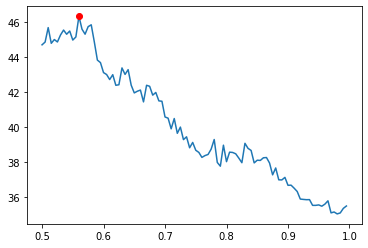

0.56


In [ ]:
total_profit_result = np.array(total_profit_result)
print('total_profit_result.shape :', total_profit_result.shape)
total_profit_sum = np.sum(total_profit_result, axis=0)
# print(total_profit_sum)

# plt.hist(x_ticks, bins=len(x_ticks),weights=total_profit_sum)
plt.plot(x_ticks, total_profit_sum)
plt.plot(x_ticks[np.argmax(total_profit_sum)], max(total_profit_sum), 'o', color='red')
plt.show()

print(x_ticks[np.argmax(total_profit_sum)])

### ***Find Best Partial***

In [ ]:
max_tp_ratio = 1.
remain_qty = 1
partial_num = 10
tp_list = list()
qty_list = list()
for i in range(partial_num, 0, -1):

  tp_list.append(max_tp_ratio * i / partial_num)
  # df['long_tp_1'] = df['ep'] + abs(df['ep'] - df['long_sl']) * tp_ratio * 2 / 3

  if i != 1:
    qty = remain_qty / 1.5
    remain_qty -= qty
  else:
    qty = remain_qty

  qty_list.append(qty)

# print(tp_list)
# print(np.array([tp_list, qty_list]).astype(np.float64))
print('total_income :', np.sum(np.prod(np.array([tp_list, qty_list]), axis=0)))

total_income : 0.9500025402631713


### ***None Realtime vs Realtime***

Pred by Real
67/67 [==============================] - 0s 1ms/step
Pred by None Real
67/67 [==============================] - 0s 2ms/step


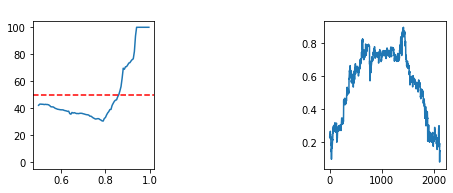

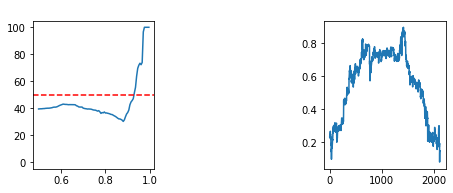


Pred by Real
65/65 [==============================] - 0s 951us/step
Pred by None Real
65/65 [==============================] - 0s 944us/step


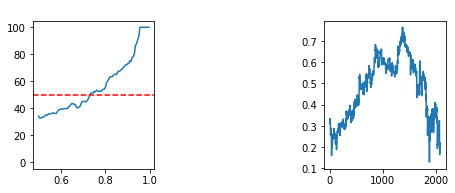

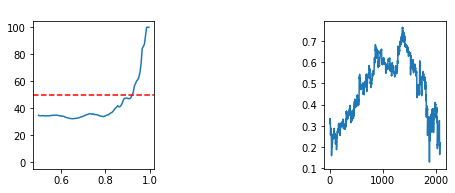


Pred by Real
65/65 [==============================] - 0s 2ms/step
Pred by None Real
65/65 [==============================] - 0s 1ms/step


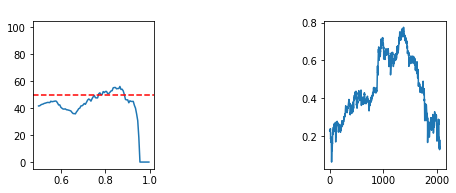

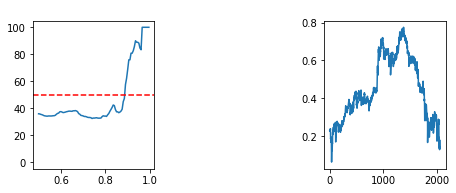


Pred by Real
67/67 [==============================] - 0s 2ms/step
Pred by None Real
67/67 [==============================] - 0s 1ms/step


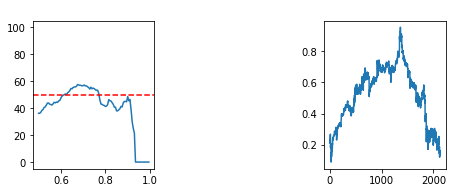

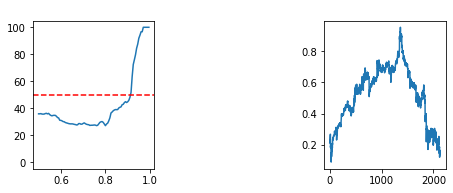


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


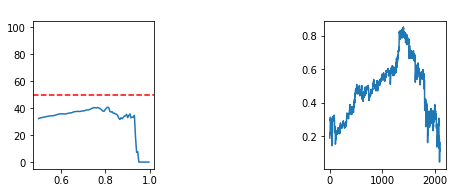

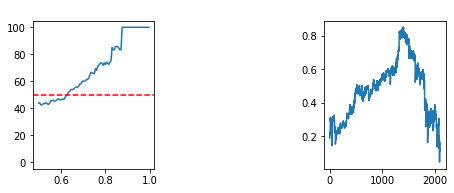


Pred by Real
68/68 [==============================] - 0s 2ms/step
Pred by None Real
68/68 [==============================] - 0s 2ms/step


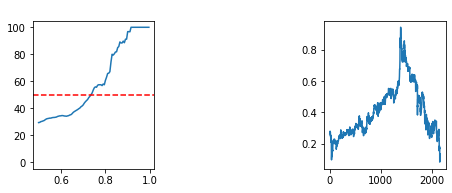

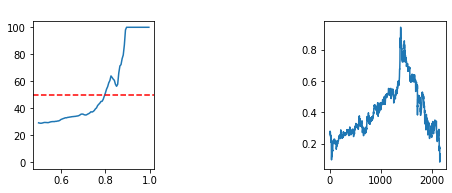


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


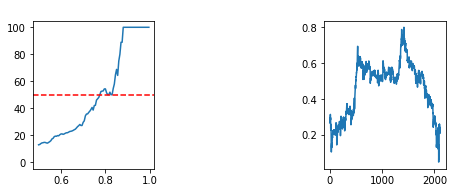

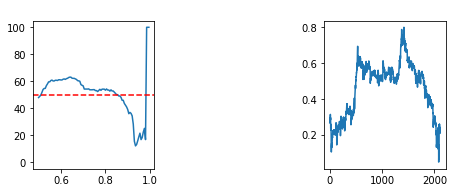


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


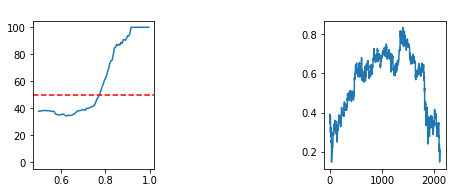

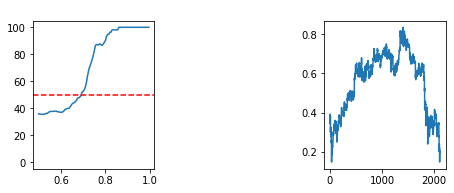


Pred by Real
Error occured :  SavedModel file does not exist at: /content/gdrive/My Drive/Colab Notebooks/Project_Stock/model/rapid_ascending 30_227_futures_rnn.hdf5/{saved_model.pbtxt|saved_model.pb}

Pred by Real
67/67 [==============================] - 0s 2ms/step
Pred by None Real
67/67 [==============================] - 0s 2ms/step


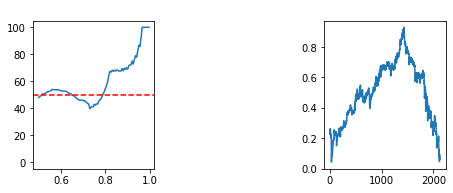

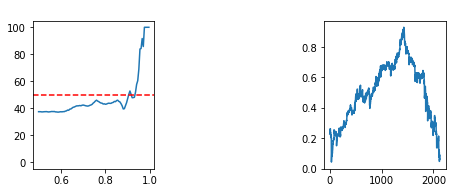


Pred by Real
66/66 [==============================] - 0s 2ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


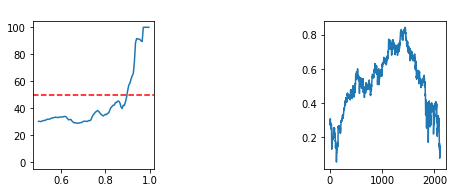

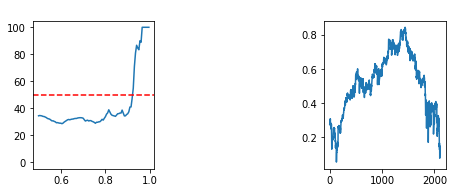


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


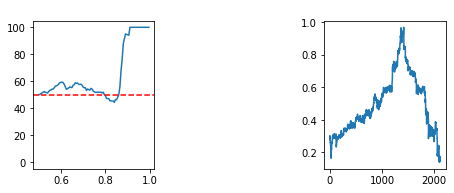

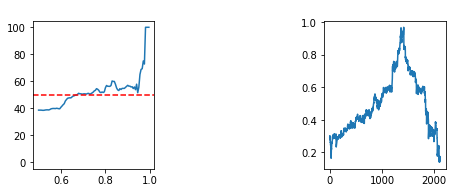


Pred by Real
65/65 [==============================] - 0s 2ms/step
Pred by None Real
65/65 [==============================] - 0s 1ms/step


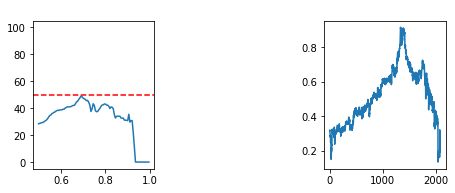

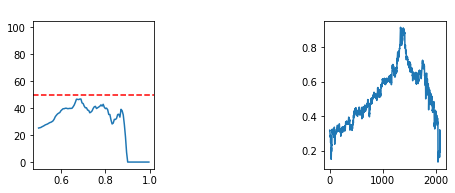


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


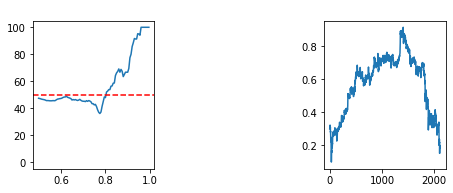

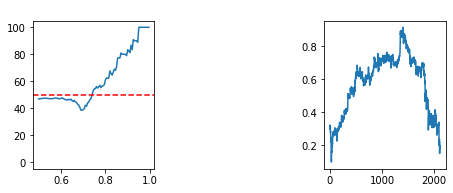


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 2ms/step


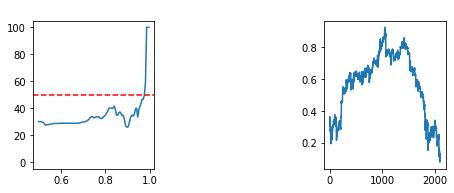

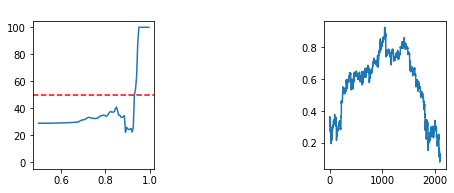


Pred by Real
67/67 [==============================] - 0s 1ms/step
Pred by None Real
67/67 [==============================] - 0s 1ms/step


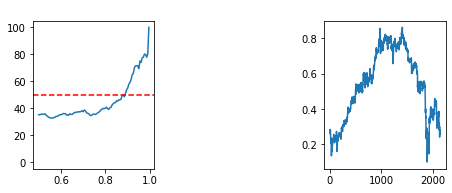

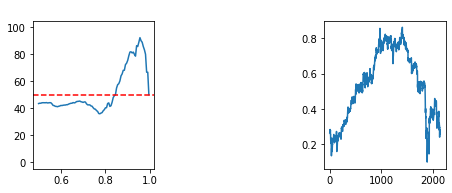


Pred by Real
64/64 [==============================] - 0s 2ms/step
Pred by None Real
64/64 [==============================] - 0s 1ms/step


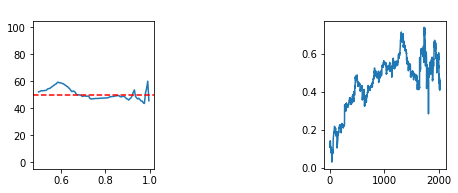

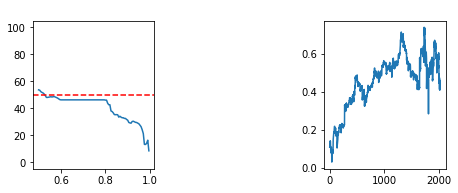


Pred by Real
63/63 [==============================] - 0s 1ms/step
Pred by None Real
63/63 [==============================] - 0s 2ms/step


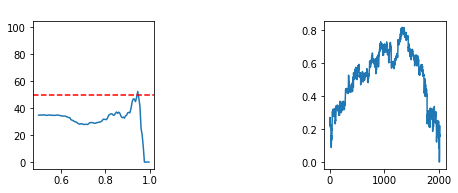

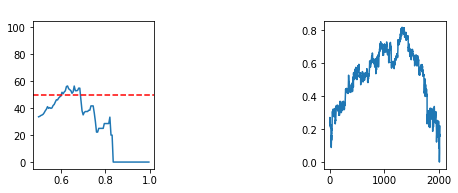


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 2ms/step


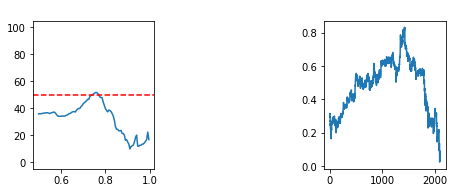

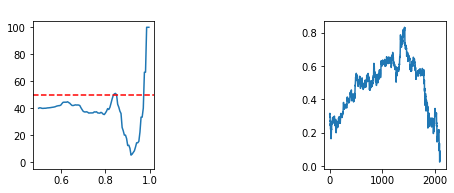


Pred by Real
63/63 [==============================] - 0s 1ms/step
Pred by None Real
63/63 [==============================] - 0s 1ms/step


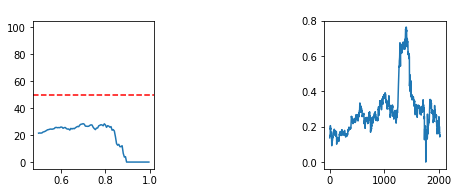

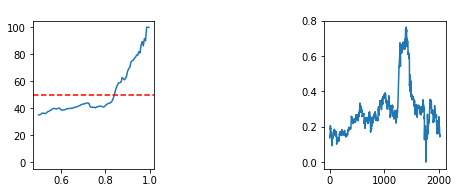


Pred by Real
64/64 [==============================] - 0s 1ms/step
Pred by None Real
64/64 [==============================] - 0s 1ms/step


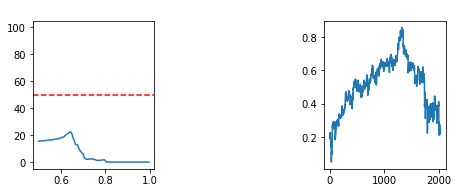

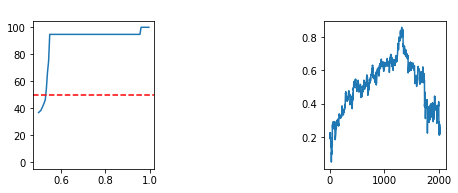


Pred by Real
67/67 [==============================] - 0s 1ms/step
Pred by None Real
67/67 [==============================] - 0s 1ms/step


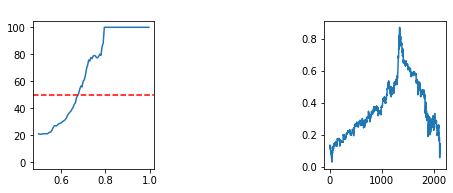

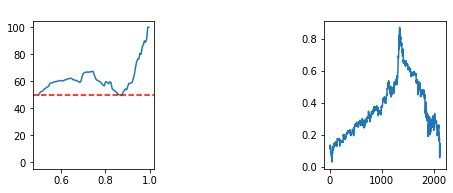


Pred by Real
65/65 [==============================] - 0s 1ms/step
Pred by None Real
65/65 [==============================] - 0s 2ms/step


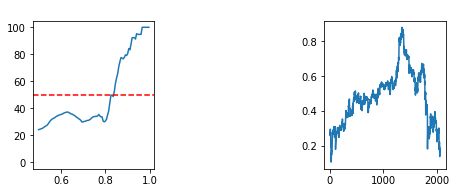

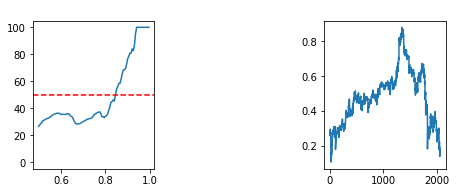


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


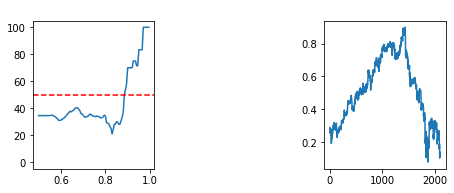

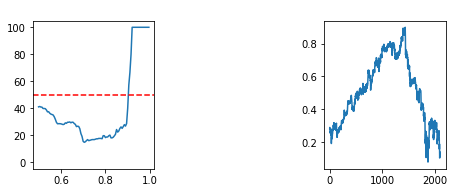


Pred by Real
67/67 [==============================] - 0s 1ms/step
Pred by None Real
67/67 [==============================] - 0s 1ms/step


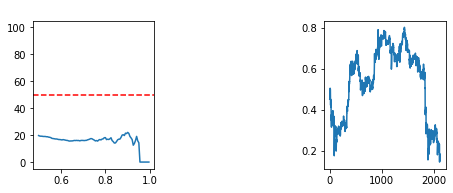

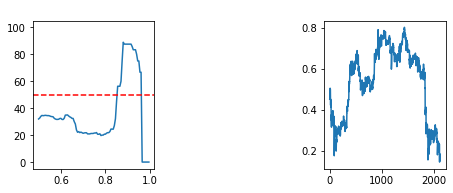


Pred by Real
69/69 [==============================] - 0s 1ms/step
Pred by None Real
69/69 [==============================] - 0s 1ms/step


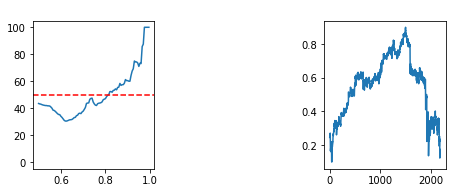

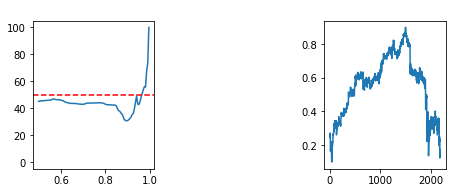


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


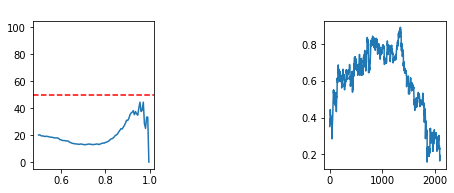

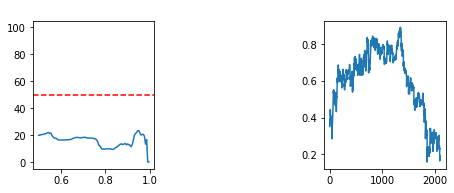


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 2ms/step


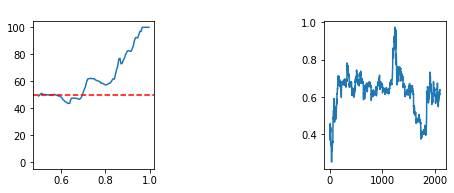

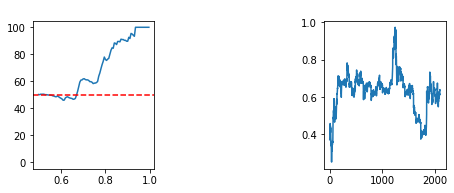


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


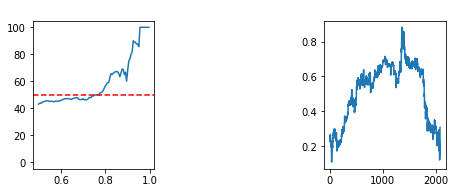

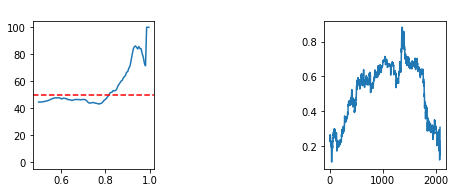


Pred by Real
66/66 [==============================] - 0s 1ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


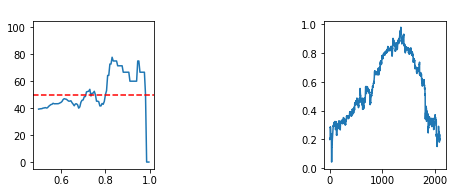

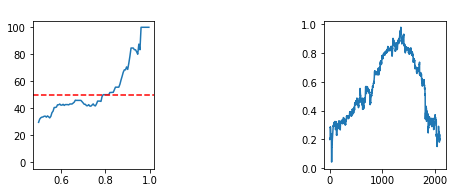


Pred by Real
68/68 [==============================] - 0s 2ms/step
Pred by None Real
68/68 [==============================] - 0s 1ms/step


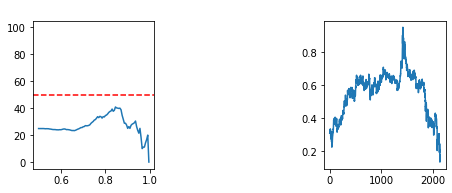

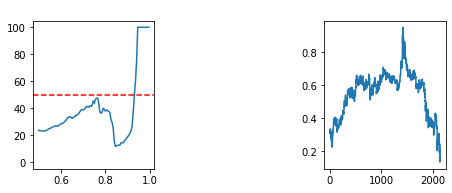


Pred by Real
67/67 [==============================] - 0s 1ms/step
Pred by None Real
67/67 [==============================] - 0s 1ms/step


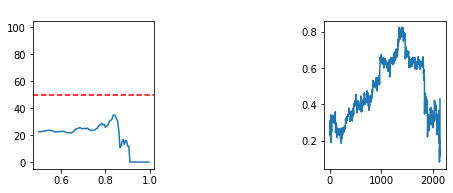

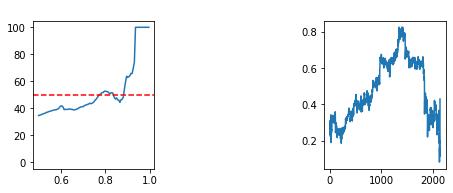


Pred by Real
64/64 [==============================] - 0s 1ms/step
Pred by None Real
64/64 [==============================] - 0s 1ms/step


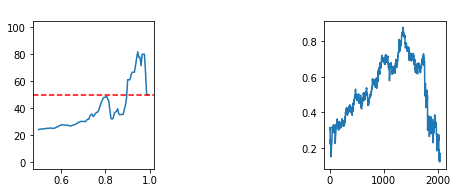

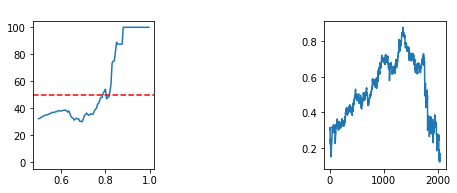


Pred by Real
66/66 [==============================] - 0s 2ms/step
Pred by None Real
66/66 [==============================] - 0s 1ms/step


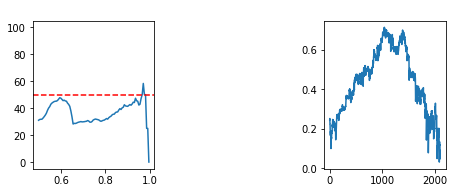

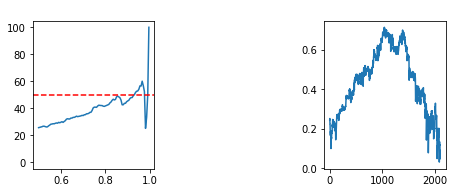


Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Made_X/Made_X 30_376.npy'

Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Made_X/Made_X 30_377.npy'

Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Made_X/Made_X 30_378.npy'

Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Made_X/Made_X 30_379.npy'

Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Made_X/Made_X 30_380.npy'

Pred by Real
Error occured :  SavedModel file does not exist at: /content/gdrive/My Drive/Colab Notebooks/Project_Stock/model/rapid_ascending 30_258_futures_rnn.hdf5/{saved_model.pbtxt|saved_model.pb}

Error occured :  [Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/Project_Stock/Ma

In [ ]:
#     Confidence value should be adjusted by min max scale in y_pred    #
from keras.models import load_model
import matplotlib.pyplot as plt

for model_num in model_range:

  try:

    #     Get Test Dataset   #
    Made_X_ = np.load(gdrive_path + 'Made_X/Made_X %s_%s.npy' % (input_data_length, model_num + 41 * 3))
    Made_Y = np.load(gdrive_path + 'Made_X/Made_Y %s_%s.npy' % (input_data_length, model_num + 41 * 3)).reshape(-1, 1)

    #       dataset 분리      #
    # dataX 구성 : VOLUME, MA, CMO, OBV, RSI, MACD, MACD_SIGNAL, MACD_OSC 
    # dataX 구성 : VOLUME, EMA1, EMA2, CMO, OBV, RSI, MACD, MACD_SIGNAL, MACD_OSC 
    # Made_X = Made_X_[:, :, [-4]]
    Made_X = Made_X_[:, :, :4]
    # print(Made_X.shape)
    # print(Made_Y.shape)
    # break

    row = Made_X.shape[1]
    col = Made_X.shape[2]

    # X_train, X_val, Y_train, Y_val = train_test_split(Made_X, Made_Y, test_size=0.3,
    #                                                   shuffle=False)

    # X_train = X_train.astype('float32')#.reshape(-1, input_data_length, col, 1)
    # X_val = X_val.astype('float32')#.reshape(-1, input_data_length, col, 1)

    X_test = Made_X.astype('float32')
    Y_test = Made_Y
    
    for model_i, model_num in enumerate([model_num, model_num + 41]):

      if model_i == 0:
        print('Pred by Real')
      else:
        print('Pred by None Real')

      model_path = gdrive_path + "model/rapid_ascending %s_%s_futures_rnn.hdf5" % (input_data_length, model_num)
      model = load_model(model_path)
      y_pred_ = model.predict(X_test, verbose=1)
      # total_y_pred_ = model.predict(Made_X, verbose=1)

      plt.figure(figsize=(10, 6))
      
      for index, y_pred_ in enumerate([y_pred_]):

        # print('len(y_pred_) :', len(y_pred_))
        target_column = y_pred_[:, [-1]]
        # column_min, column_max = train_y_pred_.min(),train_y_pred_.max()
        column_min, column_max = target_column.min(),target_column.max()
        # print(column_min, column_max)

        x_ticks = np.arange(0.5, 1, 0.005)
        # x_ticks = np.arange(0.5, column_max, 0.005) <-- column_max 대응할만한 값을 찾아야한다. 1 까지는 사용못할것
        confidence_result = list()
        for confidence in x_ticks:
          # confidence = 0.9

          # if column_max < 0.5:
          #   break
          # else:
          #   scaled_confidence = .5 + (column_max - .5) * confidence
          scaled_confidence = column_min + (column_max - column_min) * confidence

          # scaled_confidence = confidence
          # print(scaled_confidence)
          # print('confidence :', confidence)

          y_pred = np.where(target_column >= scaled_confidence, 1, 0).reshape(-1, )

          #   inverse version   #
          # confidence = 1 - confidence
          # scaled_confidence = y_pred_[:, [-1]].min() + (y_pred_[:, [-1]].max() - y_pred_[:, [-1]].min()) * confidence
          # y_pred = np.where(y_pred_[:, [-1]] <= scaled_confidence, 1, 0).reshape(-1, )

          #     결국, Categorical 은 index 값으로 value 를 나타내는 것    #
          # t_te = np.argmax(Y_val, axis=1)

          t_te = Y_test

          # print(y_pred_[:5])
          # print(Y_val[:5])
          # break

          pred_true = 0
          real_true = 0

          #       predict value 존나 높으면 True 일 확률 존나 높은건데, 그게 진짜 True가 맞냐 이걸 알고 싶은거지     #
          #       confidence를 만족하는 label이 1인 데이터 안에서 pred 1 / label 1 -> 이걸 도출해면 된다        #

          for i in range(len(y_pred)):
            if y_pred[i] == 1:  
              pred_true += 1
              if t_te[i] == y_pred[i]:
                real_true += 1

          true_true = real_true / pred_true * 100
          confidence_result.append(true_true)
          # print('True Pred / Total True : %s / %s' % (real_true, pred_true))
          # print('Accuracy : %2.f %%' % (true_true))
          # print()

        # if column_max < 0.5:
        #   continue
        
        plt.subplot(2, 4, index + 1 + model_i * 4)
        plt.plot(x_ticks, confidence_result)
        plt.axhline(50, linestyle='--', color='red')
        plt.ylim(-5, 105)
        plt.title('%s %s' % ((column_min, column_max)), color='white', fontsize=10)

        if index == 0:
          plt.subplot(2, 4, index + 3 + model_i * 4)
          plt.plot(Made_X_[:, [-1], [3]])
        elif index == 1:
          plt.subplot(2, 4, index + 3 + model_i * 4)
          plt.plot(Made_X_[:, [-1], [3]])

    plt.show()

  except Exception as e:
    print('Error occured : ', e)
  print()


### ***Check Entry points in Chart***

confidence : 0.8


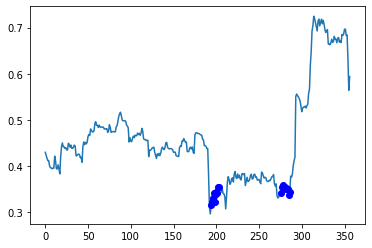

In [ ]:
#     Confidence value should be adjusted by min max scale in y_pred    #
from keras.models import load_model


confidence = 0.8
scaled_confidence = column_min + (column_max - column_min) * confidence
# print(scaled_confidence)
print('confidence :', confidence)

y_pred = np.where(target_column >= scaled_confidence, 1, 0).reshape(-1, )
t_te = np.argmax(Y_val, axis=1)

close = Made_X_[-len(X_val):, [-1], [3]]
plt.plot(close)
# plt.show()

long_marker_x = list()
long_marker_y = list()
for i in range(len(y_pred)):
  if y_pred[i] == 1:  
    if t_te[i] == y_pred[i]:
      long_marker_x.append(i)
      long_marker_y.append(close[i])
      

plt.plot(long_marker_x, long_marker_y, 'o', color='blue')
plt.show()